# Non-hateful/Toxic Trigger Analysis



# Import Libraries

In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 24.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement toolz-1.0.0 (from versions: none)
ERROR: No matching distribution found for toolz-1.0.0


In [ ]:
# Core Libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk
import torch
import shap
from IPython.display import display, HTML

# Scikit-Learn Libraries
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# XGBoost Library
from xgboost import XGBClassifier

# PyTorch Libraries
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# NLTK Libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Visualization Libraries
import plotly.graph_objects as go
from ipywidgets import widgets
import plotly.express as px  # Optional, remove if not needed
from plotly.io import to_html 
from wordcloud import WordCloud

# Integrated Gradients and LIME Libraries
from captum.attr import IntegratedGradients
from lime.lime_text import LimeTextExplainer

# Emoji handling library (if needed for emoji preprocessing)
import emoji


# Data Loading

In [ ]:
temp_1 = pd.read_csv('data/deberta_v3_labelled_3_1.csv')
temp_2 = pd.read_csv('data/deberta_v3_labelled_3_2.csv')
temp_3 = pd.read_csv('data/deberta_v3_labelled_3_3.csv')
temp_4 =  pd.read_csv('data/deberta_v3_labelled_3_4.csv')
temp_5 =  pd.read_csv('data/deberta_v3_labelled_3_5.csv')

In [ ]:
temp = pd.concat([temp_1, temp_2, temp_3, temp_4, temp_5]).reset_index(drop=True)
deberta = temp.drop_duplicates().reset_index(drop=True)

deberta['timestamp'] = pd.to_datetime(deberta['timestamp'])
deberta = deberta.sort_values(by='timestamp', ascending=True).reset_index(drop=True)

# Data Cleaning

- **Handle Missing Text**: Remove rows with missing comments (NaNs) to ensure data completeness.
- **Lowercasing**: Standardize text by converting all characters to lowercase for uniformity.
- **Abbreviation Replacement**: Replace common abbreviations (e.g., "idk" to "I don’t know") for clearer context in the text.
- **Remove Unnecessary Elements**:
  - **URLs**: Strip out web links.
  - **Mentions and Hashtags**: Remove Twitter-style mentions (`@username`) and hashtags.
  - **Markdown Links**: Clean up links embedded in Markdown format.
  - **Punctuation**: Remove punctuation to focus on meaningful words.
- **Emoji Conversion**: Translate emojis to text (e.g., "😊" becomes "smiling face") to capture emotional tone.
- **Tokenization**: Split comments into individual tokens (words).
- **Lemmatization and Stopword Removal**: Convert words to their base form (e.g., "running" → "run") and filter out common stopwords for clarity.
  
These steps produce a standardized `processed_text` column, where cleaned and refined comments enhance the focus on meaningful words for further NLP analysis.

In [ ]:
deberta_NaNs = deberta[deberta['text'].isna()].reset_index(drop=True)
deberta_cleaned = deberta[deberta['text'].notna()].reset_index(drop=True)

In [ ]:
deberta_cleaned.head()

text           timestamp  \
0  SUTD entry requirements is more or less the sa... 2020-01-01 00:00:33   
1          With jam like this, it's barely worth it. 2020-01-01 00:01:05   
2  I outside now, I guess reaching there around 0... 2020-01-01 00:12:57   
3                            The female or male cry? 2020-01-01 00:12:59   
4  bring an umbrella! it gets really hot during t... 2020-01-01 00:13:37   

       username                                               link    link_id  \
0      Twrd4321  /r/singapore/comments/eia0ap/sit_suss_or_sutd/...  t3_eia0ap   
1        557088  /r/singapore/comments/ei5a1u/how_congested_the...  t3_ei5a1u   
2  HeavyArmsJin  /r/singapore/comments/ei8j4h/whats_the_earlies...  t3_ei8j4h   
3  Tempestuous-  /r/singapore/comments/ei9klf/rsingapore_random...  t3_ei9klf   
4  WiisdomTooth  /r/singapore/comments/ei2z6d/what_is_there_to_...  t3_ei2z6d   

    parent_id       id subreddit_id  \
0  t1_fcom49y  fconqf5     t5_2qh8c   
1  t1_fcnh5ns  fconrxl     t5_2qh8c   
2   t3_ei8j4h  fcooqwc     t5_2qh8c   
3  t1_fcohcxx  fcoor03     t5_2qh8c   
4   t3_ei2z6d  fcoosvb     t5_2qh8c   

                                          moderation  BERT_2_hate  
0  {'removal_reason': None, 'collapsed': False, '...        False  
1  {'removal_reason': None, 'collapsed': False, '...        False  
2  {'removal_reason': None, 'collapsed': False, '...        False  
3  {'removal_reason': None, 'collapsed': False, '...        False  
4  {'removal_reason': None, 'collapsed': False, '...         True

In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a dictionary for common abbreviations
abbreviations = {
    "idk": "I don't know",
    "smh": "shaking my head",
    "lol": "laugh out loud",
    "btw": "by the way",
    "imo": "in my opinion",
    "brb": "be right back"
}

# Function to replace abbreviations
def replace_abbreviations(text):
    for key, value in abbreviations.items():
        text = text.replace(key, value)
    return text

# Complete preprocessing pipeline
def preprocess_text(text):
    # Step 1: Convert to lowercase
    text = text.lower()

    # Step 2: Replace abbreviations
    text = replace_abbreviations(text)

    # Step 3: Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Step 4: Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Step 5: Remove hashtags (#topic)
    text = re.sub(r'#\w+', '', text)

    # Step 6: Remove Markdown links (e.g., [text](link))
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    # Step 7: Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Step 8: Convert emojis to text
    text = emoji.demojize(text)

    # Step 9: Tokenization and lemmatization
    tokens = word_tokenize(text)

    # Step 10: Lemmatization and stopword removal, keeping only alphabetic tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]

    # Step 11: Join tokens back into a single string
    return ' '.join(tokens)

# Apply the preprocessing pipeline to the text column
deberta_cleaned['processed_text'] = deberta_cleaned['text'].fillna('').astype(str).apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#save df into a file
deberta_cleaned.to_csv('data/deberta_cleaned.csv', index=False)

# Feature Engineering #

- **Copy Original Data**: Start with a copy of `deberta_cleaned` to `data_for_xai`, preserving the original data for any future reference.

- **Parent ID Extraction**: 
  - Extract only the numeric part of the `parent_id` field to identify unique parent comments more clearly.

- **Count Toxic Responses**:
  - For each parent comment (`pure_parent_id`), count how many toxic (hate) child comments it has using the `BERT_2_hate` flag. This count helps determine if a comment can be classified as a 'trigger.'

- **Merge Toxic Counts**:
  - Merge these counts back into `data_for_xai` to indicate the number of toxic child comments for each parent comment. Fill any missing values with zero, ensuring parents with no toxic responses are accounted for.

- **Balance Dataset**:
  - Filter the dataset to keep only non-toxic parent comments and create a `trigger` label based on whether each parent comment received any toxic replies.
  - Sample 100,000 trigger and 100,000 non-trigger comments to form `balanced_df`, ensuring a balanced dataset for model training.

This feature engineering process refines the dataset for analyzing trigger comments, setting up a balanced dataset that captures both triggering and non-triggering parent comments.

In [94]:
deberta_cleaned= pd.read_csv('data/deberta_cleaned.csv')

In [ ]:
deberta_cleaned.head()

text            timestamp  \
0  SUTD entry requirements is more or less the sa...  2020-01-01 00:00:33   
1          With jam like this, it's barely worth it.  2020-01-01 00:01:05   
2  I outside now, I guess reaching there around 0...  2020-01-01 00:12:57   
3                            The female or male cry?  2020-01-01 00:12:59   
4  bring an umbrella! it gets really hot during t...  2020-01-01 00:13:37   

       username                                               link    link_id  \
0      Twrd4321  /r/singapore/comments/eia0ap/sit_suss_or_sutd/...  t3_eia0ap   
1        557088  /r/singapore/comments/ei5a1u/how_congested_the...  t3_ei5a1u   
2  HeavyArmsJin  /r/singapore/comments/ei8j4h/whats_the_earlies...  t3_ei8j4h   
3  Tempestuous-  /r/singapore/comments/ei9klf/rsingapore_random...  t3_ei9klf   
4  WiisdomTooth  /r/singapore/comments/ei2z6d/what_is_there_to_...  t3_ei2z6d   

    parent_id       id subreddit_id  \
0  t1_fcom49y  fconqf5     t5_2qh8c   
1  t1_fcnh5ns  fconrxl     t5_2qh8c   
2   t3_ei8j4h  fcooqwc     t5_2qh8c   
3  t1_fcohcxx  fcoor03     t5_2qh8c   
4   t3_ei2z6d  fcoosvb     t5_2qh8c   

                                          moderation  BERT_2_hate  \
0  {'removal_reason': None, 'collapsed': False, '...        False   
1  {'removal_reason': None, 'collapsed': False, '...        False   
2  {'removal_reason': None, 'collapsed': False, '...        False   
3  {'removal_reason': None, 'collapsed': False, '...        False   
4  {'removal_reason': None, 'collapsed': False, '...        False   

                                      processed_text  
0                   sutd entry requirement le nusntu  
1                              jam like barely worth  
2             outside guess reaching around fine hor  
3                                    female male cry  
4  bring umbrella get really hot day get motion s...

In [95]:
import pandas as pd

# Step 1: Copy deberta_cleaned to data_for_xai to avoid modifying the original DataFrame
data_for_xai = deberta_cleaned.copy()

# Step 2: Extract the numeric portion of 'parent_id' (i.e., pure_parent_id)
data_for_xai['pure_parent_id'] = data_for_xai['parent_id'].apply(lambda x: str(x).split('_')[-1] if '_' in str(x) else None)

# Step 3: Group by pure_parent_id and count the number of toxic (hate) child comments for each parent
toxic_child_counts = data_for_xai[data_for_xai['BERT_2_hate'] == 1].groupby('pure_parent_id')['BERT_2_hate'].count().reset_index()
toxic_child_counts.columns = ['pure_parent_id', 'toxic_child_count']

# Step 4: Merge the toxic child counts back into data_for_xai using pure_parent_id
data_for_xai = pd.merge(data_for_xai, toxic_child_counts, on='pure_parent_id', how='left')

# Fill NaN values in 'toxic_child_count' with 0 (for parents with no toxic child comments)
data_for_xai['toxic_child_count'] = data_for_xai['toxic_child_count'].fillna(0)

In [ ]:
data_for_xai.head()

text           timestamp  \
0  SUTD entry requirements is more or less the sa... 2020-01-01 00:00:33   
1          With jam like this, it's barely worth it. 2020-01-01 00:01:05   
2  I outside now, I guess reaching there around 0... 2020-01-01 00:12:57   
3                            The female or male cry? 2020-01-01 00:12:59   
4  bring an umbrella! it gets really hot during t... 2020-01-01 00:13:37   

       username                                               link    link_id  \
0      Twrd4321  /r/singapore/comments/eia0ap/sit_suss_or_sutd/...  t3_eia0ap   
1        557088  /r/singapore/comments/ei5a1u/how_congested_the...  t3_ei5a1u   
2  HeavyArmsJin  /r/singapore/comments/ei8j4h/whats_the_earlies...  t3_ei8j4h   
3  Tempestuous-  /r/singapore/comments/ei9klf/rsingapore_random...  t3_ei9klf   
4  WiisdomTooth  /r/singapore/comments/ei2z6d/what_is_there_to_...  t3_ei2z6d   

    parent_id       id subreddit_id  \
0  t1_fcom49y  fconqf5     t5_2qh8c   
1  t1_fcnh5ns  fconrxl     t5_2qh8c   
2   t3_ei8j4h  fcooqwc     t5_2qh8c   
3  t1_fcohcxx  fcoor03     t5_2qh8c   
4   t3_ei2z6d  fcoosvb     t5_2qh8c   

                                          moderation  BERT_2_hate  \
0  {'removal_reason': None, 'collapsed': False, '...        False   
1  {'removal_reason': None, 'collapsed': False, '...        False   
2  {'removal_reason': None, 'collapsed': False, '...        False   
3  {'removal_reason': None, 'collapsed': False, '...        False   
4  {'removal_reason': None, 'collapsed': False, '...         True   

                                      processed_text pure_parent_id  \
0                   sutd entry requirement le nusntu        fcom49y   
1                              jam like barely worth        fcnh5ns   
2             outside guess reaching around fine hor         ei8j4h   
3                                    female male cry        fcohcxx   
4  bring umbrella get really hot day get motion s...         ei2z6d   

   toxic_child_count  trigger  
0                0.0        0  
1                0.0        0  
2                0.0        0  
3                1.0        1  
4                2.0        1

In [96]:
df=data_for_xai[['pure_parent_id', 'toxic_child_count']]

In [8]:
print(df.head())
print(df.shape)

  pure_parent_id  toxic_child_count
0        fcom49y                0.0
1        fcnh5ns                0.0
2         ei8j4h                0.0
3        fcohcxx                1.0
4         ei2z6d                2.0
(4504330, 2)


In [97]:
df_unique=df.drop_duplicates()
df_unique.shape

(2148302, 2)

In [98]:
merged_df=deberta_cleaned.merge(df_unique, left_on='id', right_on='pure_parent_id', how='left')

In [99]:
merged_df = merged_df.dropna(subset=['toxic_child_count'])

In [13]:
print(merged_df.head())
print(merged_df.shape)

                                                 text            timestamp  \
0   SUTD entry requirements is more or less the sa...  2020-01-01 00:00:33   
3                             The female or male cry?  2020-01-01 00:12:59   
6   I’m doing duty for both NYE and CNY Eve this y...  2020-01-01 00:17:12   
9                     The standard koo uu koo uu one.  2020-01-01 00:21:37   
12  got home @ like 4+ from reddit meetup and just...  2020-01-01 00:28:32   

                username                                               link  \
0               Twrd4321  /r/singapore/comments/eia0ap/sit_suss_or_sutd/...   
3           Tempestuous-  /r/singapore/comments/ei9klf/rsingapore_random...   
6   ArmsHeavySoKneesWeak  /r/singapore/comments/ei5lec/lets_take_a_momen...   
9            TheSodaDude  /r/singapore/comments/ei9klf/rsingapore_random...   
12               gmdotes  /r/singapore/comments/ei9klf/rsingapore_random...   

      link_id   parent_id       id subreddit_id  \
0   t

In [100]:
merged_df = merged_df[(merged_df['BERT_2_hate'] == 0)]

In [102]:
merged_df2=merged_df.copy()

In [103]:
merged_df2=merged_df[['processed_text','toxic_child_count']]

In [105]:
merged_df2.shape

(1250893, 2)

In [106]:
merged_df2.to_csv('data/merged_df2.csv')

In [ ]:
merged_df['trigger'] = merged_df['toxic_child_count'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
trigger_1_sample = merged_df[merged_df['trigger'] == 1].sample(n=100000, random_state=42)

# Step 2: Subsample 100,000 rows where trigger == 0
trigger_0_sample = merged_df[merged_df['trigger'] == 0].sample(n=100000, random_state=42)

# Step 3: Concatenate the two samples to create the balanced DataFrame
balanced_df = pd.concat([trigger_1_sample, trigger_0_sample]).reset_index(drop=True)

# Display the new balanced DataFrame
print(balanced_df.head())
print(balanced_df.shape)

                                                text           timestamp  \
0            TIL Kickapoo also got different flavour 2020-11-29 12:00:32   
1  You hypothetically should hypothetically try a... 2023-09-06 11:27:43   
2                             Uwu bird. No question. 2023-07-15 10:05:29   
3  Lol, this is like me blasting Crystal Method w... 2023-06-10 01:39:21   
4  mai misunderstood me bro, there’s nothing food... 2022-06-20 14:08:59   

           username                                               link  \
0        elpipita20  /r/singapore/comments/k32kqo/its_amazing_that_...   
1       Micro_Lumen  /r/singapore/comments/16bfbm8/gojek_driver_ref...   
2  Common-Metal8578  /r/singapore/comments/14ztjz0/rsingapore_rando...   
3          ham_rain  /r/singapore/comments/145i74o/rsingapore_rando...   
4     bueytahanliao  /r/singapore/comments/vg5soh/rsingapore_random...   

      link_id   parent_id       id subreddit_id  \
0   t3_k32kqo  t1_ge0e4qd  ge0qurs     t5_2qh8c

In [17]:
merged_df2=pd.read_csv('data/merged_df2.csv')
merged_df2.head()

processed_text  toxic_child_count
0                   sutd entry requirement le nusntu                0.0
1                                    female male cry                0.0
2  duty nye cny eve year offinlieu unit edited ad...                1.0
3                         standard koo uu koo uu one                0.0
4    china one get withdraw money bank atm singapore                0.0

# Trigger Counts on various threshold #

- **Threshold-Based Trigger Classification**: 
  - We experimented with varying thresholds to classify a parent comment as a "trigger" based on the number of toxic child comments it received. For each threshold level, a `trigger` label was generated, marking comments with toxic child counts above the threshold.

- **Counting Trigger Instances**: 
  - For each threshold, we calculated the total number of comments classified as triggers. This count shows how many parent comments have more than the specified threshold of toxic responses, helping us gauge the sensitivity of our trigger identification method.

- **Visualization of Trigger Counts**:
  - We plotted the trigger counts across different thresholds using Plotly. The plot illustrates the relationship between threshold levels and the count of triggers, with each point displaying the exact number of trigger comments for clarity.

This threshold analysis allows us to see how changes in the toxic child comment threshold impact the identification of trigger comments, providing insights into the sensitivity and specificity of different threshold levels.

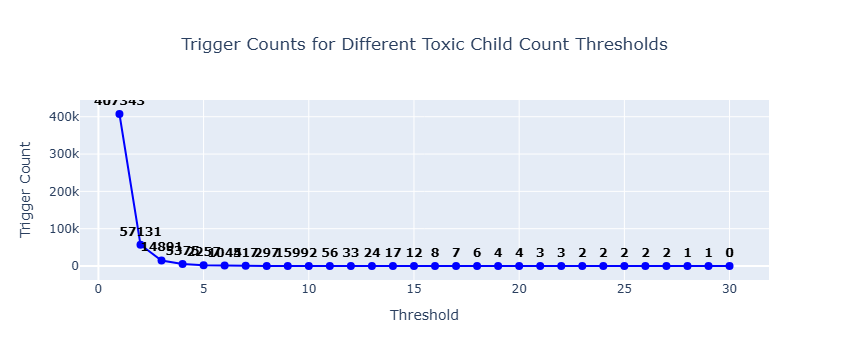

In [65]:
# Initialize a list to store results for each threshold
trigger_data = []

# Loop through each threshold value from 0 up to the maximum toxic_child_count
for threshold in range(int(merged_df2['toxic_child_count'].max()) + 1):
    # Create the 'trigger' column based on the current threshold
    merged_df2['trigger'] = merged_df2['toxic_child_count'].apply(lambda x: 1 if x > threshold else 0)
    
    # Count the rows where 'trigger' is 1
    trigger_count = merged_df2['trigger'].sum()
    
    # Append the threshold and corresponding trigger count to the list
    trigger_data.append({'toxic_child_count_threshold': threshold+1, 'trigger_count': trigger_count})

# Convert the list to a DataFrame for plotting
trigger_df = pd.DataFrame(trigger_data)

# Plot using Plotly with markers and displaying values at each point
fig = px.line(
    trigger_df,
    x='toxic_child_count_threshold',
    y='trigger_count',
    title='Trigger Counts for Different Toxic Child Count Thresholds',
    labels={'toxic_child_count_threshold': 'Threshold', 'trigger_count': 'Trigger Count'},
    markers=True,
    text='trigger_count'
)

# Update layout to show bold text above markers without using yshift
fig.update_traces(
    texttemplate="<b>%{text}</b>",  # Make text bold
    marker=dict(size=8, color='blue'),  # Customize marker size and color if needed
    line=dict(color='blue', width=2),   # Customize line color and width if needed
    textfont=dict(size=12),             # Adjust font size if necessary
    textposition="top center",
    textfont_color='black'
)

# Additional layout adjustments
fig.update_layout(
    title_x=0.5,  # Center the title
    xaxis_title="Threshold",
    yaxis_title="Trigger Count",
)

fig.show()


In [233]:
trigger_df

toxic_child_count_threshold  trigger_count
0                             1         407343
1                             2          57131
2                             3          14891
3                             4           5375
4                             5           2257
5                             6           1044
6                             7            517
7                             8            297
8                             9            159
9                            10             92
10                           11             56
11                           12             33
12                           13             24
13                           14             17
14                           15             12
15                           16              8
16                           17              7
17                           18              6
18                           19              4
19                           20              4
20                           21              3
21                           22              3
22                           23              2
23                           24              2
24                           25              2
25                           26              2
26                           27              2
27                           28              1
28                           29              1
29                           30              0

# TFIDF on threshold=1 (baseline testing) #

- **Data Preparation**:
  - Loaded the balanced dataset, consisting of 100,000 "trigger" and 100,000 "non-trigger" samples, with `threshold=1`.
  - Split the dataset into training and testing sets (80% for training, 20% for testing).
  
- **Text Vectorization with TF-IDF**:
  - Applied TF-IDF Vectorization with n-grams ranging from 1 to 3 and a maximum of 5000 features.
  - Used `MaxAbsScaler` to normalize TF-IDF values across features, preparing the data for model training.

- **Model Training and Evaluation**:
  - **Ridge Classifier**:
    - Tuned the regularization parameter `alpha` using GridSearchCV.
    - Best `alpha` identified was 500, optimizing the model's accuracy.
    - Calculated classification metrics, including accuracy, precision, recall, and ROC-AUC.
    - Top contributing words identified using SHAP analysis.
  
  - **Logistic Regression**:
    - Tuned `C` (regularization) and solver options (liblinear, saga) using GridSearchCV.
    - Best parameters optimized for accuracy and interpretability.
    - SHAP values for top features helped highlight the most influential words for trigger classification.
  
  - **XGBoost Classifier**:
    - Tuned `max_depth`, `learning_rate`, and `n_estimators` to optimize non-linear feature interactions.
    - SHAP analysis provided insights into the most impactful words for trigger classification.

  - **Neural Network**:
    - Implemented a neural network with one hidden layer to capture deeper, non-linear relationships in text.
    - Tuned hyperparameters, including learning rate, number of hidden units, and batch size, to find the best configuration.
    - Used Integrated Gradients as an XAI method, allowing us to understand the influence of individual words on model predictions.

- **Explainable AI (XAI) for Interpretability**:
  - Used SHAP (SHapley Additive exPlanations) for Ridge Classifier, Logistic Regression, and XGBoost to interpret feature importance.
  - For the neural network, applied Integrated Gradients to highlight the top words contributing to the classification of "trigger" comments.
  
This baseline analysis, using `threshold=1`, establishes an initial benchmark for detecting comments that may inadvertently lead to toxic interactions.

In [ ]:
balanced_df=pd.read_csv('data/balanced_df.csv')

In [ ]:
balanced_df.head()

text            timestamp  \
0            TIL Kickapoo also got different flavour  2020-11-29 12:00:32   
1  You hypothetically should hypothetically try a...  2023-09-06 11:27:43   
2                             Uwu bird. No question.  2023-07-15 10:05:29   
3  Lol, this is like me blasting Crystal Method w...  2023-06-10 01:39:21   
4  mai misunderstood me bro, there’s nothing food...  2022-06-20 14:08:59   

           username                                               link  \
0        elpipita20  /r/singapore/comments/k32kqo/its_amazing_that_...   
1       Micro_Lumen  /r/singapore/comments/16bfbm8/gojek_driver_ref...   
2  Common-Metal8578  /r/singapore/comments/14ztjz0/rsingapore_rando...   
3          ham_rain  /r/singapore/comments/145i74o/rsingapore_rando...   
4     bueytahanliao  /r/singapore/comments/vg5soh/rsingapore_random...   

      link_id   parent_id       id subreddit_id  \
0   t3_k32kqo  t1_ge0e4qd  ge0qurs     t5_2qh8c   
1  t3_16bfbm8  t1_jzd5c6l  jzd5okl     t5_2qh8c   
2  t3_14ztjz0  t1_js1qssi  js1rvli     t5_2qh8c   
3  t3_145i74o  t1_jnlqpr9  jnlvbx8     t5_2qh8c   
4   t3_vg5soh  t1_id26t8m  id271db     t5_2qh8c   

                                          moderation  BERT_2_hate  \
0  {'removal_reason': None, 'collapsed': False, '...        False   
1  {'banned_at_utc': None, 'mod_reason_by': None,...        False   
2  {'banned_at_utc': None, 'mod_reason_by': None,...        False   
3  {'banned_at_utc': None, 'mod_reason_by': None,...        False   
4  {'controversiality': 0, 'collapsed_reason_code...        False   

                                      processed_text pure_parent_id  \
0            til kickapoo also got different flavour        ge0qurs   
1  hypothetically hypothetically try asking mothe...        jzd5okl   
2                                  uwu bird question        js1rvli   
3  laugh loud like blasting crystal method partic...        jnlvbx8   
4  mai misunderstood bro nothing food solve u dun...        id271db   

   toxic_child_count  trigger  
0                1.0        1  
1                1.0        1  
2                1.0        1  
3                1.0        1  
4                1.0        1

In [ ]:
X=pd.DataFrame(balanced_df['processed_text'])
y=balanced_df['trigger']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(160000, 1)
(40000, 1)
(160000,)
(40000,)


In [ ]:
X_train['processed_text'] = X_train['processed_text'].fillna('')
X_test['processed_text'] = X_test['processed_text'].fillna('')

In [ ]:
X_train['processed_text'] = X_train[X_train['processed_text'] != ''] 
X_test['processed_text'] = X_test[X_test['processed_text'] != '']

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3),max_features=5000)  # Adjust max_features if needed

# Fit the vectorizer on the training data and transform both train and test data
X_train_tfidf = vectorizer.fit_transform(X_train['processed_text'])
X_test_tfidf = vectorizer.transform(X_test['processed_text'])

In [ ]:
# Initialize the scaler
scaler = MaxAbsScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_tfidf = scaler.fit_transform(X_train_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)

## Ridge Classifier  ##

In [ ]:
# Define parameter grid for Ridge Classifier
param_grid_ridge = {
    'alpha': [500, 800, 1000]  # Regularization strength for Ridge Classifier
}

# Initialize Ridge Classifier
ridge_clf = RidgeClassifier()

# Perform GridSearchCV for Ridge Classifier
grid_search_ridge = GridSearchCV(estimator=ridge_clf, param_grid=param_grid_ridge, scoring='accuracy', cv=10, n_jobs=-1)
grid_search_ridge.fit(X_train_tfidf, y_train)

# Get the best model and parameters
best_ridge_clf = grid_search_ridge.best_estimator_
print(f"Best parameters for Ridge Classifier (no dim red): {grid_search_ridge.best_params_}")

# Make predictions and evaluate
y_pred_ridge = best_ridge_clf.predict(X_test_tfidf)
print("Ridge Classifier (No Dim Red) Classification Report:\n", classification_report(y_test, y_pred_ridge))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ridge))
roc_auc_ridge = roc_auc_score(y_test, y_pred_ridge)
print(f"ROC-AUC: {roc_auc_ridge}")


Best parameters for Ridge Classifier (no dim red): {'alpha': 500}
Ridge Classifier (No Dim Red) Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.54      0.56     20007
           1       0.56      0.59      0.57     19993

    accuracy                           0.56     40000
   macro avg       0.56      0.56      0.56     40000
weighted avg       0.56      0.56      0.56     40000

Confusion Matrix:
 [[10856  9151]
 [ 8256 11737]]
ROC-AUC: 0.5648327779420153


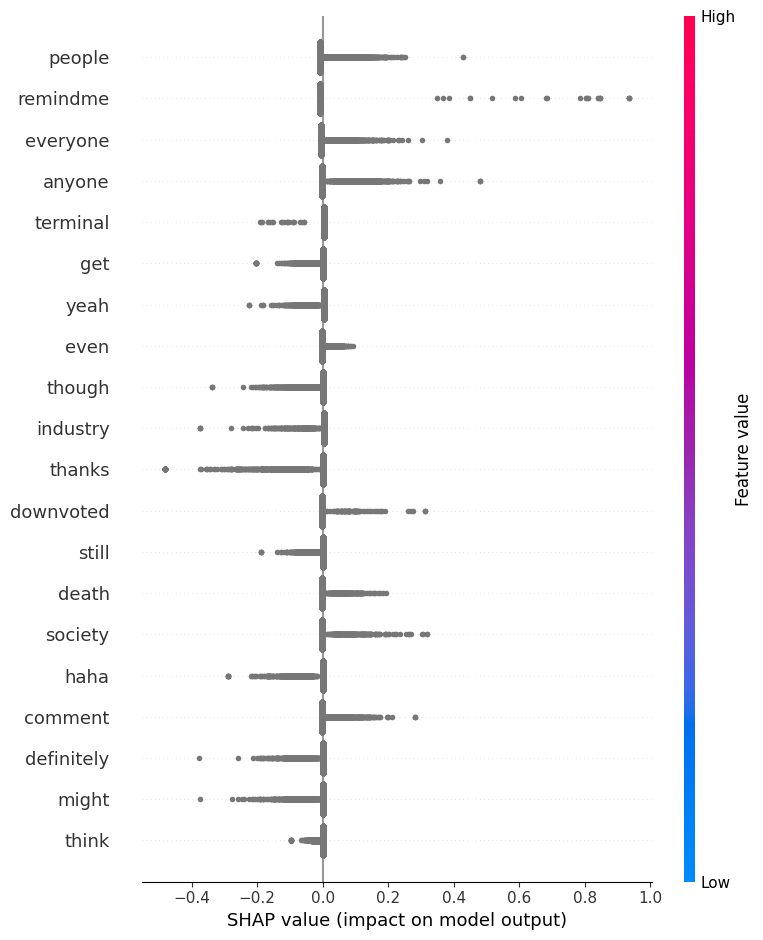

In [ ]:
# Initialize SHAP LinearExplainer for the Ridge Classifier
explainer = shap.LinearExplainer(best_ridge_clf, X_train_tfidf, feature_perturbation="interventional")

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_tfidf)

# Get feature names from the TF-IDF vectorizer for interpretability
feature_names = vectorizer.get_feature_names_out()

# SHAP summary plot for all features (words/n-grams)
shap.summary_plot(shap_values, X_test_tfidf, feature_names=feature_names)


In [ ]:
# Step 1: Convert SHAP values to a DataFrame for easier analysis
shap_df = pd.DataFrame(shap_values, columns=feature_names)

# Step 2: Calculate the mean SHAP value for each word across all test instances
mean_shap_values = shap_df.mean(axis=0)

# Step 3: Filter for words with high mean SHAP values indicating contribution to the trigger class
# For positive SHAP values contributing to "trigger" class, use a threshold (e.g., > 0.05)
top_trigger_words = mean_shap_values[mean_shap_values > 0].sort_values(ascending=False)  # Adjust threshold if needed

# Display the top words causing the trigger
print("Top words contributing to the trigger class:")
print(top_trigger_words[:50])




Top words contributing to the trigger class:
terminal       0.003910
guy            0.002559
industry       0.002489
frequently     0.002446
outcome        0.002407
yeah           0.002212
pie            0.001974
contract       0.001919
steam          0.001618
catching       0.001527
harder         0.001523
application    0.001458
nah            0.001457
dropped        0.001391
definitely     0.001378
east coast     0.001354
edit           0.001305
fully          0.001270
pocket         0.001254
buy            0.001177
later          0.001170
tho            0.001141
form           0.001127
usual          0.001120
able           0.001115
uncertainty    0.001073
haha           0.001066
prior          0.001063
beginning      0.001018
im saying      0.000998
focusing       0.000983
smc            0.000976
slide          0.000954
afford         0.000933
girl           0.000924
likely         0.000920
feature        0.000912
yup            0.000900
veg            0.000891
print          0.00

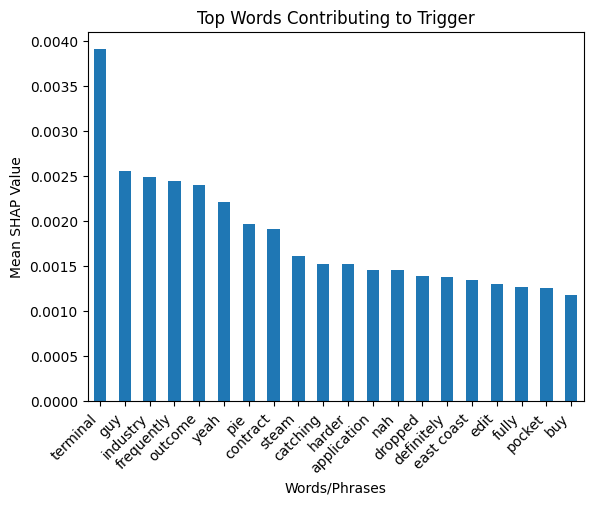

In [ ]:
# Optional: Visualize top trigger words with a bar plot
top_trigger_words.head(20).plot(kind='bar', title="Top Words Contributing to Trigger")
plt.xlabel("Words/Phrases")
plt.ylabel("Mean SHAP Value")
plt.xticks(rotation=45, ha='right')
plt.show()

## Logistic Regression ##

In [ ]:
# Define parameter grid for Logistic Regression
param_grid_logreg = {
    'C': [0.1, 1.0, 10.0],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga']  # Use solvers compatible with L2 penalty
}

# Initialize Logistic Regression
logreg_clf = LogisticRegression(max_iter=1000)

# Perform GridSearchCV for Logistic Regression
grid_search_logreg = GridSearchCV(estimator=logreg_clf, param_grid=param_grid_logreg, scoring='f1', cv=3, n_jobs=-1)
grid_search_logreg.fit(X_train_tfidf, y_train)

# Get the best model and parameters
best_logreg_clf = grid_search_logreg.best_estimator_
print(f"Best parameters for Logistic Regression (no dim red): {grid_search_logreg.best_params_}")

# Make predictions and evaluate
y_pred_logreg = best_logreg_clf.predict(X_test_tfidf)
print("Logistic Regression (No Dim Red) Classification Report:\n", classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)
print(f"ROC-AUC: {roc_auc_logreg}")


Best parameters for Logistic Regression (no dim red): {'C': 0.1, 'solver': 'liblinear'}
Logistic Regression (No Dim Red) Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.56      0.56     20007
           1       0.56      0.58      0.57     19993

    accuracy                           0.57     40000
   macro avg       0.57      0.57      0.57     40000
weighted avg       0.57      0.57      0.57     40000

Confusion Matrix:
 [[11106  8901]
 [ 8444 11549]]
ROC-AUC: 0.5663789456314208


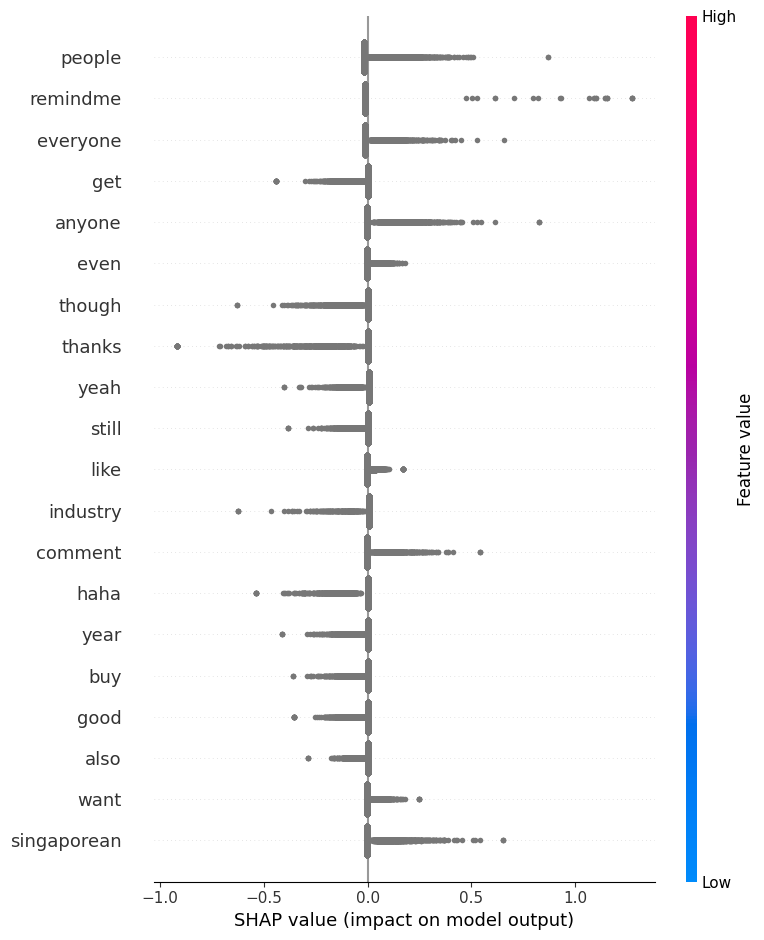

In [ ]:
# Initialize SHAP LinearExplainer for the Ridge Classifier
explainer = shap.LinearExplainer(best_logreg_clf, X_train_tfidf, feature_perturbation="interventional")

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_tfidf)

# Get feature names from the TF-IDF vectorizer for interpretability
feature_names = vectorizer.get_feature_names_out()

# SHAP summary plot for all features (words/n-grams)
shap.summary_plot(shap_values, X_test_tfidf, feature_names=feature_names)

In [ ]:
# Step 1: Convert SHAP values to a DataFrame for easier analysis
shap_df = pd.DataFrame(shap_values, columns=feature_names)

# Step 2: Calculate the mean SHAP value for each word across all test instances
mean_shap_values = shap_df.mean(axis=0)

# Step 3: Filter for words with high mean SHAP values indicating contribution to the trigger class
# For positive SHAP values contributing to "trigger" class, use a threshold (e.g., > 0.05)
top_trigger_words = mean_shap_values[mean_shap_values > 0].sort_values(ascending=False)  # Adjust threshold if needed

# Display the top words causing the trigger
print("Top words contributing to the trigger class:")
print(top_trigger_words[:50])


Top words contributing to the trigger class:
guy            0.005023
industry       0.004155
yeah           0.003930
terminal       0.003642
contract       0.002839
buy            0.002506
outcome        0.002474
definitely     0.002278
application    0.002277
frequently     0.002266
pie            0.002064
edit           0.002034
haha           0.001981
nah            0.001946
able           0.001887
tho            0.001870
fully          0.001730
harder         0.001726
later          0.001675
covid          0.001673
form           0.001649
girl           0.001575
steam          0.001570
possible       0.001519
likely         0.001513
guess          0.001487
already        0.001463
usual          0.001449
whats          0.001436
afford         0.001393
dropped        0.001385
yup            0.001385
life           0.001379
wp             0.001376
think          0.001339
super          0.001327
east coast     0.001302
would          0.001300
flight         0.001297
cost           0.00

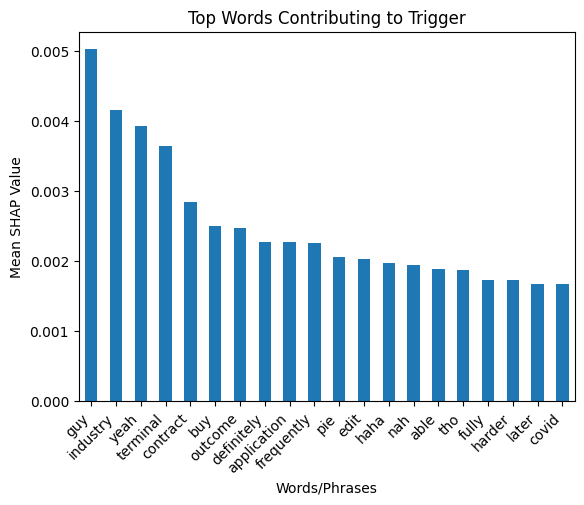

In [ ]:
# Optional: Visualize top trigger words with a bar plot
top_trigger_words.head(20).plot(kind='bar', title="Top Words Contributing to Trigger")
plt.xlabel("Words/Phrases")
plt.ylabel("Mean SHAP Value")
plt.xticks(rotation=45, ha='right')
plt.show()

## XGB ##

In [ ]:
param_grid = {
    'max_depth': [3, 5],             # Control the depth of the trees
    'learning_rate': [0.1, 0.2],  # Step size shrinkage for each boosting step
    'n_estimators': [100, 200],     # Number of boosting rounds
}

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=3,n_jobs=-1)

# Fit the GridSearchCV model to the training data (TF-IDF vectorized)
grid_search.fit(X_train_tfidf, y_train)

# Get the best model from GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Print the best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

# Make predictions on the test set using the best model
y_pred_xgb = best_xgb_model.predict(X_test_tfidf)

# Evaluate the model's performance
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_xgb)
print(f"ROC-AUC: {roc_auc}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.41      0.47     20007
           1       0.53      0.67      0.60     19993

    accuracy                           0.54     40000
   macro avg       0.55      0.54      0.53     40000
weighted avg       0.55      0.54      0.53     40000

Confusion Matrix:
 [[ 8201 11806]
 [ 6514 13479]]
ROC-AUC: 0.5420462489006656


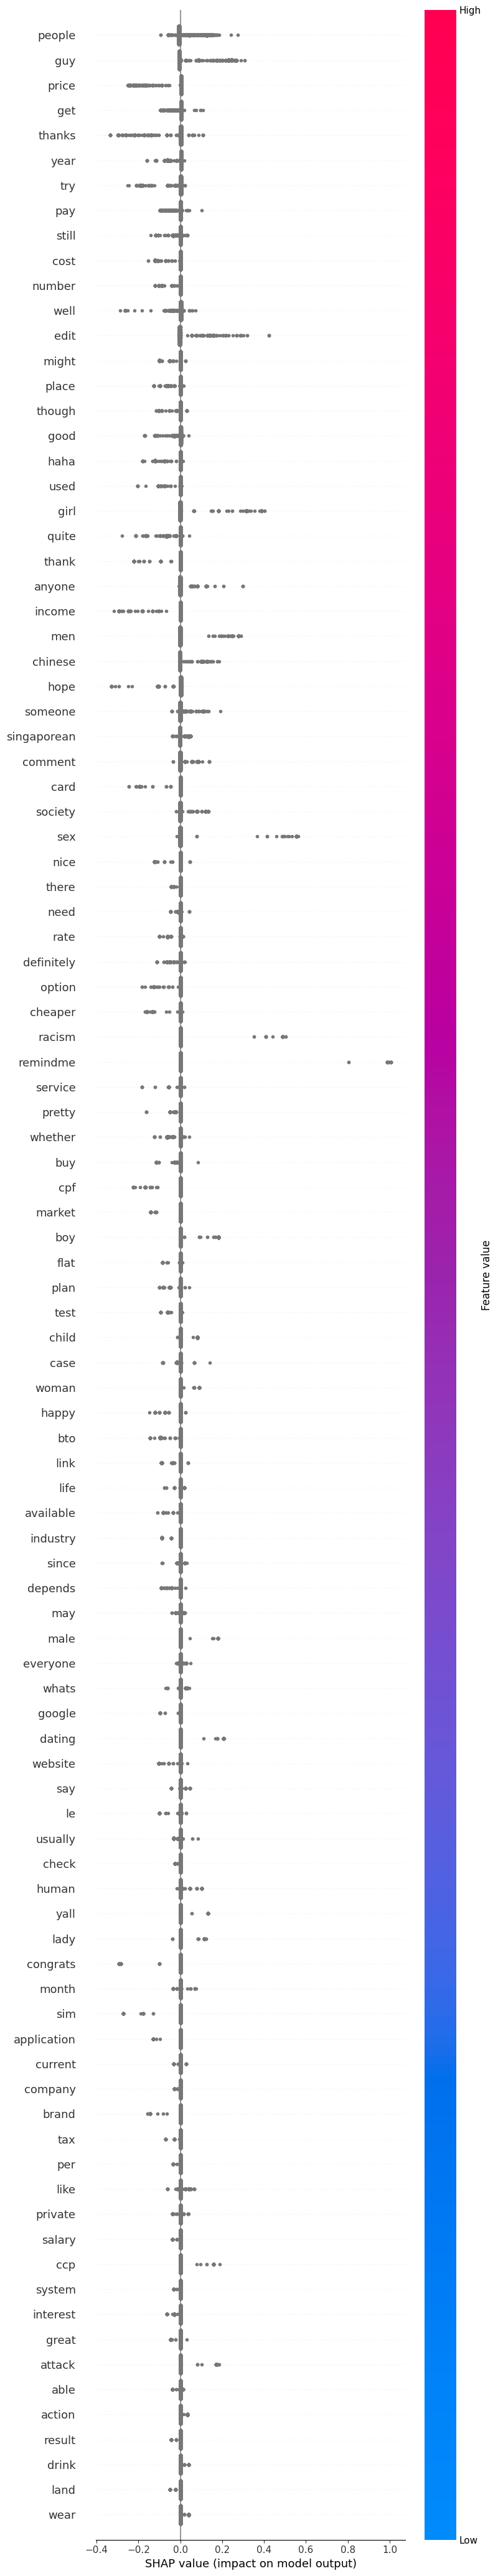

In [ ]:
# Create a SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(best_xgb_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_tfidf)

# Display more words (features) in the summary plot by setting max_display
shap.summary_plot(shap_values, X_test_tfidf, feature_names=vectorizer.get_feature_names_out(), max_display=100)  # Adjust max_display as needed

In [ ]:
import shap

# Initialize SHAP's JavaScript visualization
shap.initjs()

# Convert sparse matrix to dense
X_test_tfidf_dense = X_test_tfidf.toarray()

# Get top N features (e.g., top 20) by absolute SHAP values for a single instance
top_n = 50
shap_values_instance = shap_values[0]  # SHAP values for the first instance
top_features_idx = abs(shap_values_instance).argsort()[-top_n:]  # Indices of top features

# Filter to show only top features in force plot
shap.force_plot(
    explainer.expected_value,
    shap_values_instance[top_features_idx],
    X_test_tfidf_dense[0][top_features_idx],
    feature_names=vectorizer.get_feature_names_out()[top_features_idx]
)


In [ ]:
# Assuming `shap_values` is the SHAP values array for the dataset, and `y_test` is the true labels
# Convert SHAP values and feature names into a DataFrame for easier analysis
shap_df = pd.DataFrame(shap_values, columns=vectorizer.get_feature_names_out())

# Add the true labels to the SHAP DataFrame
shap_df['label'] = y_test.values  # Assuming `y_test` is the true label series

# Filter for instances where the label is "trigger" (e.g., label == 1)
trigger_shap_df = shap_df[shap_df['label'] == 1].drop(columns='label')

# Calculate the mean SHAP value for each word for "trigger" instances
mean_shap_trigger = trigger_shap_df.mean().sort_values(ascending=False)

# Filter out words with positive SHAP values, indicating they push towards trigger
trigger_words = mean_shap_trigger[mean_shap_trigger > 0]

# Display the top words contributing to the trigger
print("Top words that cause the trigger:")
print(trigger_words.head(20))  # Adjust the number to display more or fewer words


Top words that cause the trigger:
guy         0.001571
girl        0.000859
remindme    0.000678
price       0.000585
thanks      0.000494
people      0.000441
edit        0.000431
try         0.000427
might       0.000318
sex         0.000316
cpf         0.000296
year        0.000274
haha        0.000247
good        0.000234
used        0.000206
anyone      0.000193
chinese     0.000183
option      0.000176
woman       0.000173
though      0.000165
dtype: float32


## Neural Networks ##

In [149]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_units):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Define hyperparameter options
learning_rates = [0.001, 0.0001]
hidden_units_options = [64, 128]
batch_sizes = [32, 64]
num_epochs = 10  # You can set this as fixed

# Placeholder for the best accuracy score and best parameters
best_accuracy = 0
best_params = {}

# Run grid search over the hyperparameters
for learning_rate in learning_rates:
    for hidden_units in hidden_units_options:
        for batch_size in batch_sizes:
            print(f"Training with learning rate={learning_rate}, hidden_units={hidden_units}, batch_size={batch_size}")

            # Define DataLoader with the current batch size
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Instantiate model, loss function, and optimizer with current hyperparameters
            input_size = X_train_tfidf.shape[1]
            model = NeuralNet(input_size, hidden_units)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Training loop
            for epoch in range(num_epochs):
                model.train()
                for X_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    y_pred = model(X_batch).squeeze()
                    loss = criterion(y_pred, y_batch.float())
                    loss.backward()
                    optimizer.step()

            # Evaluate model on test set
            model.eval()
            y_pred_list = []
            y_true_list = []
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    y_pred = model(X_batch).squeeze()
                    y_pred_list.extend((y_pred > 0.5).float().numpy())
                    y_true_list.extend(y_batch.numpy())

            # Calculate accuracy for current configuration
            accuracy = accuracy_score(y_true_list, y_pred_list)
            print(f"Accuracy: {accuracy}")

            # Update best accuracy and best parameters if this configuration is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'learning_rate': learning_rate,
                    'hidden_units': hidden_units,
                    'batch_size': batch_size
                }

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")


Training with learning rate=0.001, hidden_units=64, batch_size=32
Accuracy: 0.6002214839424141
Training with learning rate=0.001, hidden_units=64, batch_size=64
Accuracy: 0.5991140642303433
Training with learning rate=0.001, hidden_units=128, batch_size=32
Accuracy: 0.6212624584717608
Training with learning rate=0.001, hidden_units=128, batch_size=64
Accuracy: 0.602436323366556
Training with learning rate=0.0001, hidden_units=64, batch_size=32
Accuracy: 0.6245847176079734
Training with learning rate=0.0001, hidden_units=64, batch_size=64
Accuracy: 0.636766334440753
Training with learning rate=0.0001, hidden_units=128, batch_size=32
Accuracy: 0.6135105204872646
Training with learning rate=0.0001, hidden_units=128, batch_size=64
Accuracy: 0.6323366555924695
Best Accuracy: 0.636766334440753
Best Parameters: {'learning_rate': 0.0001, 'hidden_units': 64, 'batch_size': 64}


Top words contributing to the trigger class:
completely      0.029738
care            0.028577
someone else    0.026430
else            0.021558
miss            0.016732
youve           0.010941
someone         0.009641
agree           0.001485
need            0.001258
thats           0.001014
great           0.000894
know            0.000886
tax             0.000848
government      0.000847
better          0.000802
haha            0.000752
fee             0.000742
flat            0.000714
though          0.000695
hope            0.000690
Name: shap_value, dtype: float64


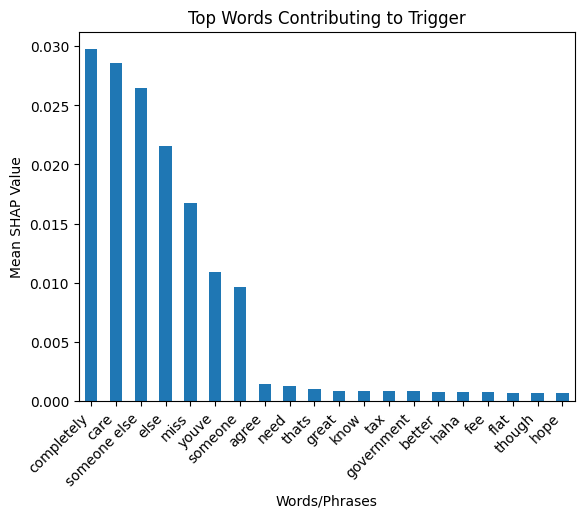

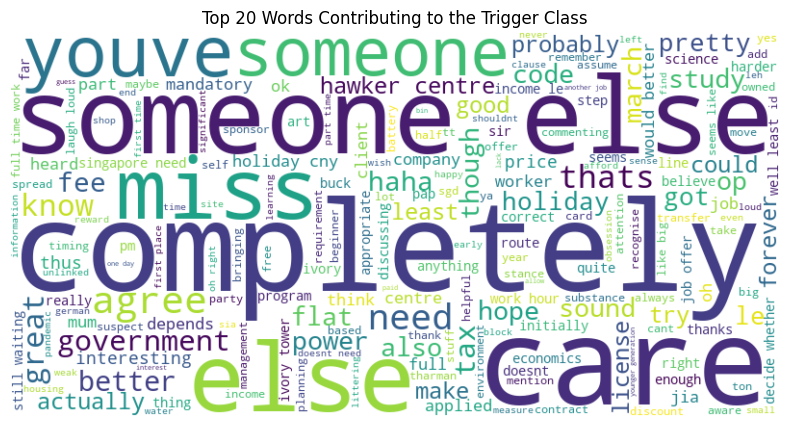

In [116]:
# Ensure model is in evaluation mode
best_model.eval()

# Use GradientExplainer from SHAP for neural networks with PyTorch
explainer = shap.GradientExplainer(best_model, X_train_tensor)

# Calculate SHAP values for a subset of the test set (to save time)
shap_values = explainer.shap_values(X_test_tensor[:100])  # Adjust the subset size if needed

# Extract SHAP values for class 1 (since it's a binary classification, use index 0 or 1)
shap_values_class_1 = shap_values[0]  # or shap_values[1] depending on the class you're analyzing

# Flatten the SHAP values and get feature names
shap_values_flattened = shap_values_class_1.flatten()
feature_names = vectorizer.get_feature_names_out()

# Ensure the length of the feature names matches the SHAP values
assert len(feature_names) == len(shap_values_flattened), "Shape mismatch between feature names and SHAP values."

# Convert SHAP values to a DataFrame
shap_df = pd.DataFrame(shap_values_flattened, columns=['shap_value'], index=feature_names)

# Calculate the mean SHAP value for each word across all test instances
mean_shap_values = shap_df.groupby(shap_df.index)['shap_value'].mean()

# Filter for words with high mean SHAP values contributing to the trigger class
top_trigger_words = mean_shap_values[mean_shap_values > 0].sort_values(ascending=False)

# Display the top words contributing to the trigger
print("Top words contributing to the trigger class:")
print(top_trigger_words[:20])

# Plot top trigger words
top_trigger_words.head(20).plot(kind='bar', title="Top Words Contributing to Trigger")
plt.xlabel("Words/Phrases")
plt.ylabel("Mean SHAP Value")
plt.xticks(rotation=45, ha='right')
plt.show()

# Generate and display word cloud
word_freq = top_trigger_words.to_dict()
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 20 Words Contributing to the Trigger Class")
plt.show()


In [144]:
# Ensure `best_model` is in evaluation mode
best_model.eval()

# Define the function for LIME to make predictions with `best_model`
def lime_predict(texts):
    # Transform texts to TF-IDF vectors
    text_tfidf = vectorizer.transform(texts)
    
    # Convert to dense format and then to PyTorch tensor
    inputs = torch.tensor(text_tfidf.toarray(), dtype=torch.float32)
    
    # Move inputs to the same device as `best_model`
    inputs = inputs.to(next(best_model.parameters()).device)
    
    # Predict probabilities using the neural network
    with torch.no_grad():
        outputs = best_model(inputs).squeeze()
    
    # Convert model output to probabilities
    probs = torch.cat([1 - outputs.unsqueeze(1), outputs.unsqueeze(1)], dim=1)
    return probs.cpu().numpy()  # Return as numpy array for LIME

# Initialize LIME explainer for text
explainer = LimeTextExplainer(class_names=["Non-trigger", "Trigger"])

# Sample text for explanation
sample_text = "Sian lah, got so much work today, but never mind, just tahan a bit"

# Generate explanation with LIME
exp = explainer.explain_instance(
    sample_text, 
    lime_predict, 
    num_features=10  # Number of words to highlight
)

# Display explanation in Jupyter Notebook
exp.show_in_notebook(text=True)  # For Jupyter Notebook

# Alternatively, print explanation weights
print(exp.as_list())  # List of words and their contribution scores

[('today', 0.058478811514922895), ('got', -0.044550077286553344), ('mind', 0.0328830187268132), ('lah', -0.02479941354182163), ('never', -0.021900834600099783), ('Sian', 0.011998206355744216), ('bit', 0.004523392165800253), ('work', 0.0042025287953589684), ('much', 0.002033487720975888), ('so', -0.0003327178057138993)]


Top 10 words for the sample text based on Integrated Gradients:
Word: comment, Attribution: 0.0738080845575479
Word: random, Attribution: 0.07136434329137548
Word: example, Attribution: -0.012602239251135343
Word: want, Attribution: -0.0322453576473105


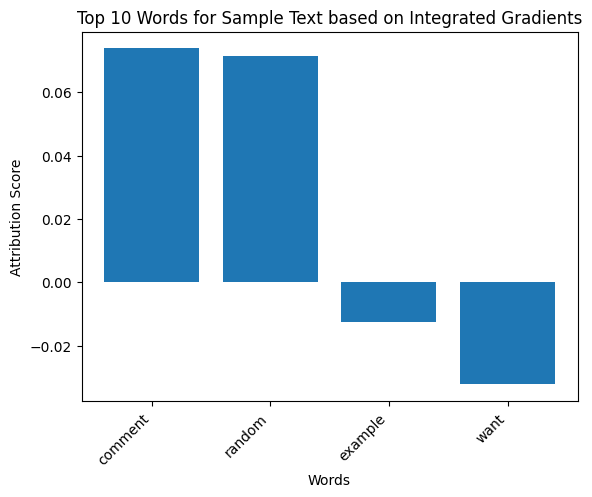

In [164]:
ig = IntegratedGradients(best_model)

# Define a sample random text to analyze
sample_text = "This is an example of a random comment that we want to analyze."

# Vectorize the sample text using the same TF-IDF vectorizer as used in training
sample_tfidf = vectorizer.transform([sample_text]).toarray()
input_tensor = torch.tensor(sample_tfidf, dtype=torch.float32)

# Get the feature names from the TF-IDF vectorizer
words = vectorizer.get_feature_names_out()

# Compute attributions using Integrated Gradients for the output class
attributions, delta = ig.attribute(input_tensor, target=0, return_convergence_delta=True)

# Convert attributions to a numpy array for easy manipulation
attributions_np = attributions.detach().numpy()[0]

# Zip words with their corresponding attribution values for this sample text
word_attributions = list(zip(words, attributions_np))

# Filter out words with zero attributions
non_zero_word_attributions = [(word, attr) for word, attr in word_attributions if abs(attr) > 0]

# Sort words by their attribution value (descending) to find the most impactful words
sorted_word_attributions = sorted(non_zero_word_attributions, key=lambda x: x[1], reverse=True)

# Display the top 10 most significant words for this sample text based on attribution scores
print(f"Top 10 words for the sample text based on Integrated Gradients:")
for word, attr in sorted_word_attributions[:10]:
    print(f"Word: {word}, Attribution: {attr}")

# Optionally, plot the top 10 most impactful words for the sample text
top_words, top_attributions = zip(*sorted_word_attributions[:10])
plt.bar(top_words, top_attributions)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Words")
plt.ylabel("Attribution Score")
plt.title("Top 10 Words for Sample Text based on Integrated Gradients")
plt.show()

In [165]:
# Define your sample text
sample_text = "This is an example of a random comment that we want to analyze"

# Tokenize the sample text manually
sample_words = sample_text.split()

# Vectorize the sample text using the TF-IDF vectorizer
sample_tfidf = vectorizer.transform([sample_text]).toarray()
input_tensor = torch.tensor(sample_tfidf, dtype=torch.float32)

# Compute attributions using Integrated Gradients
ig = IntegratedGradients(best_model)
attributions, delta = ig.attribute(input_tensor, return_convergence_delta=True)

# Convert attributions to numpy array
attributions_np = attributions.detach().numpy()[0]

# Get the words from TF-IDF and map them to their attributions
words = vectorizer.get_feature_names_out()
word_attributions = dict(zip(words, attributions_np))

# For each word in sample_text, retrieve attribution or assign zero if not found
final_tokens = []
final_attributions = []
for word in sample_words:
    final_tokens.append(word)
    final_attributions.append(word_attributions.get(word, 0))  # Use 0 if word not in TF-IDF

# Visualize attributions with HTML
html_text = ""
for token, score in zip(final_tokens, final_attributions):
    # Color red for positive attribution and green for negative attribution
    color = f"rgba(255, 0, 0, {min(1, abs(score) * 3)})" if score > 0 else f"rgba(0, 255, 0, {min(1, abs(score) * 3)})"
    style = "font-weight: bold;" if abs(score) > 0.05 else ""
    html_text += f"<span style='background-color: {color}; {style}'>{token} </span>"

display(HTML(html_text))


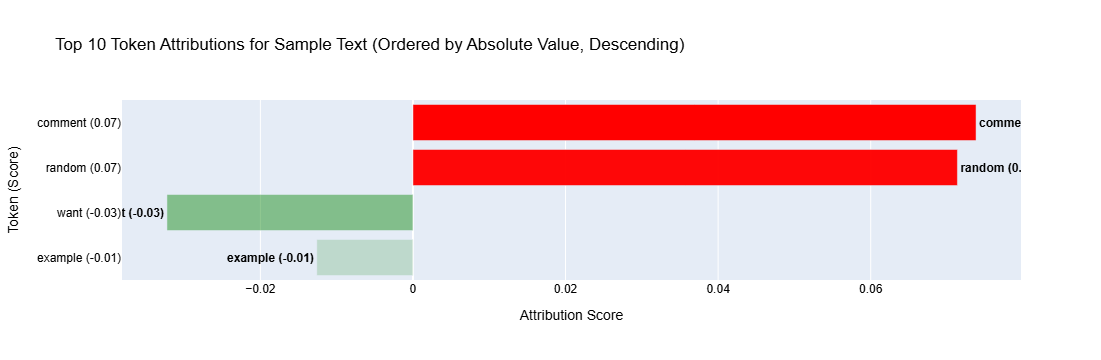

In [166]:
# Example random text
sample_text = "This is an example of a random comment that we want to analyze."

# Vectorize the sample text using the TF-IDF vectorizer
sample_tfidf = vectorizer.transform([sample_text]).toarray()
input_tensor = torch.tensor(sample_tfidf, dtype=torch.float32)

# Get the words corresponding to the features from the TF-IDF vectorizer
words = vectorizer.get_feature_names_out()

# Compute attributions using Integrated Gradients for the output class
attributions, delta = ig.attribute(input_tensor, return_convergence_delta=True)

# Convert attributions to numpy array for easier handling
attributions_np = attributions.detach().numpy()[0]

# Zip words with their corresponding attribution values for this sample
word_attributions = list(zip(words, attributions_np))

# Filter out words with zero attributions
non_zero_word_attributions = [(word, attr) for word, attr in word_attributions if abs(attr) > 0]

# Sort words by their attribution value (descending)
sorted_word_attributions = sorted(non_zero_word_attributions, key=lambda x: abs(x[1]), reverse=True)[:10]

# Convert to DataFrame for easy manipulation
df = pd.DataFrame(sorted_word_attributions, columns=["Token", "Attribution Score"])
df["Token + Score"] = df["Token"] + " (" + df["Attribution Score"].round(2).astype(str) + ")"
df = df[::-1]  # Reverse for descending y-axis order

# Set colors with varying intensity based on the attribution score
max_abs_score = max(abs(df["Attribution Score"]))
colors = [
    f'rgba(255, 0, 0, {min(1, abs(score) / max_abs_score)})' if score > 0 else 
    f'rgba(0, 128, 0, {min(1, abs(score) / max_abs_score)})' 
    for score in df["Attribution Score"]
]

# Prepare text positions based on score magnitude
text_positions = ["inside" if abs(score) > 0.1 else "outside" for score in df["Attribution Score"]]

# Create the bar chart
fig = go.Figure(go.Bar(
    x=df["Attribution Score"],
    y=df["Token + Score"],
    orientation='h',
    marker=dict(color=colors),
    text=["<b>" + label + "</b>" for label in df["Token + Score"]],  # Bold labels
    textposition=text_positions,
    texttemplate='%{text}'
))

# Update layout to maintain the sorted order on the y-axis in descending and set font to bold
fig.update_layout(
    title="Top 10 Token Attributions for Sample Text (Ordered by Absolute Value, Descending)",
    xaxis_title="Attribution Score",
    yaxis_title="Token (Score)",
    yaxis=dict(categoryarray=df["Token + Score"], categoryorder="array"),
    font=dict(family="Arial", size=12, color="black")
)

fig.show()

# Model Performance Across Varying Thresholds #

- **Objective**: To evaluate and compare model performance across a range of thresholds for "toxic child count," ensuring robustness and reliability in detecting trigger comments.

- **Data Loading & Preprocessing**:
  - Loaded the preprocessed data and initialized thresholds from 1 to 5.
  - For each threshold, labeled parent comments as triggers based on toxic child count, balancing the dataset by sampling equal trigger and non-trigger instances.

- **Model Training and Evaluation**:
  - **Ridge Classifier**:
    - Tuned the regularization parameter `alpha` with GridSearchCV and recorded accuracy, precision, recall, F1-score, and ROC-AUC.
  - **Logistic Regression**:
    - Tuned `C`, `penalty`, and `solver` parameters to optimize performance, using GridSearchCV for model selection.
  - **XGBoost Classifier**:
    - Optimized learning rate, max depth, and number of estimators, evaluating accuracy across thresholds.
  - **Neural Network**:
    - Configured with varied learning rates, hidden unit sizes, and batch sizes, running grid search to capture optimal hyperparameters. 
    - Used fixed random seeds for reproducibility in neural network training, ensuring consistent results.

- **Performance Results**:
  - Stored model performance metrics (precision, recall, F1-score, accuracy, and ROC-AUC) across thresholds for comparison.
  - Combined results into a single DataFrame, allowing for efficient sorting and filtering by threshold and model.

- **Visualization**:
  - Created an interactive line plot showing accuracy scores across models and thresholds.
  - Developed an interactive table with dropdown selections for threshold and model, allowing detailed exploration of performance metrics.

This comprehensive threshold analysis provides a basis for selecting the most effective threshold and model, balancing sensitivity and specificity in trigger detection.

In [167]:
# Load and preprocess data
merged_df = pd.read_csv('data/merged_df2.csv')
merged_df = merged_df.dropna(subset=['processed_text'])

# Define thresholds and initialize results list
thresholds = [1, 2, 3, 4, 5]


In [195]:
ridge_results = {
    'Threshold': [],
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Accuracy': [],
    'ROC-AUC': []
}

# Define parameter grid for Ridge Classifier
param_grid_ridge = {'alpha': [500, 800, 1000]}

for i in thresholds:
    print(f"\nProcessing threshold {i} for Ridge Classifier")

    merged_df['trigger'] = merged_df['toxic_child_count'].apply(lambda x: 1 if x > i else 0)
    trigger_1_sample = merged_df[merged_df['trigger'] == 1]
    trigger_0_sample = merged_df[merged_df['trigger'] == 0].sample(n=trigger_1_sample.shape[0], random_state=4264)
    balanced_df = pd.concat([trigger_1_sample, trigger_0_sample]).reset_index(drop=True)
    
    X = pd.DataFrame(balanced_df['processed_text'])
    y = balanced_df['trigger']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train['processed_text'])
    X_test_tfidf = vectorizer.transform(X_test['processed_text'])
    scaler = MaxAbsScaler()
    X_train_tfidf = scaler.fit_transform(X_train_tfidf)
    X_test_tfidf = scaler.transform(X_test_tfidf)
    
    # Hyperparameter tuning with GridSearchCV
    ridge_clf = RidgeClassifier(random_state=4264)
    grid_search_ridge = GridSearchCV(estimator=ridge_clf, param_grid=param_grid_ridge, scoring='accuracy', cv=10, n_jobs=-1)
    grid_search_ridge.fit(X_train_tfidf, y_train)
    best_ridge_clf = grid_search_ridge.best_estimator_
    
    y_pred = best_ridge_clf.predict(X_test_tfidf)
    
    # Store metrics
    ridge_results['Threshold'].append(i)
    ridge_results['Model'].append("Ridge Classifier")
    ridge_results['Precision'].append(precision_score(y_test, y_pred))
    ridge_results['Recall'].append(recall_score(y_test, y_pred))
    ridge_results['F1-Score'].append(f1_score(y_test, y_pred))
    ridge_results['Accuracy'].append(accuracy_score(y_test, y_pred))
    ridge_results['ROC-AUC'].append(roc_auc_score(y_test, y_pred))

ridge_results_df = pd.DataFrame(ridge_results)
print(ridge_results_df)


Processing threshold 1 for Ridge Classifier

Processing threshold 2 for Ridge Classifier

Processing threshold 3 for Ridge Classifier

Processing threshold 4 for Ridge Classifier

Processing threshold 5 for Ridge Classifier
   Threshold             Model  Precision    Recall  F1-Score  Accuracy  \
0          1  Ridge Classifier   0.620394  0.552622  0.584550  0.604166   
1          2  Ridge Classifier   0.662322  0.558442  0.605962  0.633876   
2          3  Ridge Classifier   0.664980  0.611163  0.636937  0.651628   
3          4  Ridge Classifier   0.705224  0.408207  0.517100  0.609081   
4          5  Ridge Classifier   0.724409  0.429907  0.539589  0.624402   

    ROC-AUC  
0  0.604573  
1  0.634502  
2  0.651628  
3  0.614331  
4  0.629169  


In [196]:
logreg_results = {
    'Threshold': [],
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Accuracy': [],
    'ROC-AUC': []
}

param_grid_logreg = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

for i in thresholds:
    print(f"\nProcessing threshold {i} for Logistic Regression")

    merged_df['trigger'] = merged_df['toxic_child_count'].apply(lambda x: 1 if x > i else 0)
    trigger_1_sample = merged_df[merged_df['trigger'] == 1]
    trigger_0_sample = merged_df[merged_df['trigger'] == 0].sample(n=trigger_1_sample.shape[0], random_state=4264)
    balanced_df = pd.concat([trigger_1_sample, trigger_0_sample]).reset_index(drop=True)
    
    X = pd.DataFrame(balanced_df['processed_text'])
    y = balanced_df['trigger']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train['processed_text'])
    X_test_tfidf = vectorizer.transform(X_test['processed_text'])
    scaler = MaxAbsScaler()
    X_train_tfidf = scaler.fit_transform(X_train_tfidf)
    X_test_tfidf = scaler.transform(X_test_tfidf)
    
    logreg_clf = LogisticRegression(max_iter=1000,random_state=4264)
    grid_search_logreg = GridSearchCV(estimator=logreg_clf, param_grid=param_grid_logreg, scoring='accuracy', cv=10, n_jobs=-1)
    grid_search_logreg.fit(X_train_tfidf, y_train)
    best_logreg_clf = grid_search_logreg.best_estimator_

    y_pred = best_logreg_clf.predict(X_test_tfidf)
    
    # Store metrics
    logreg_results['Threshold'].append(i)
    logreg_results['Model'].append("Logistic Regression")
    logreg_results['Precision'].append(precision_score(y_test, y_pred))
    logreg_results['Recall'].append(recall_score(y_test, y_pred))
    logreg_results['F1-Score'].append(f1_score(y_test, y_pred))
    logreg_results['Accuracy'].append(accuracy_score(y_test, y_pred))
    logreg_results['ROC-AUC'].append(roc_auc_score(y_test, y_pred))

logreg_results_df = pd.DataFrame(logreg_results)
print(logreg_results_df)



Processing threshold 1 for Logistic Regression

Processing threshold 2 for Logistic Regression

Processing threshold 3 for Logistic Regression

Processing threshold 4 for Logistic Regression

Processing threshold 5 for Logistic Regression
   Threshold                Model  Precision    Recall  F1-Score  Accuracy  \
0          1  Logistic Regression   0.622767  0.593348  0.607702  0.613968   
1          2  Logistic Regression   0.651910  0.608059  0.629221  0.638744   
2          3  Logistic Regression   0.660213  0.634419  0.647059  0.653953   
3          4  Logistic Regression   0.677922  0.563715  0.615566  0.638981   
4          5  Logistic Regression   0.697802  0.593458  0.641414  0.660287   

    ROC-AUC  
0  0.614130  
1  0.638999  
2  0.653953  
3  0.640948  
4  0.661925  


In [227]:
xgb_results = {
    'Threshold': [],
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Accuracy': [],
    'ROC-AUC': []
}

param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

for i in thresholds:
    print(f"\nProcessing threshold {i} for XGBoost Classifier")

    merged_df['trigger'] = merged_df['toxic_child_count'].apply(lambda x: 1 if x > i else 0)
    trigger_1_sample = merged_df[merged_df['trigger'] == 1]
    trigger_0_sample = merged_df[merged_df['trigger'] == 0].sample(n=trigger_1_sample.shape[0], random_state=4264)
    balanced_df = pd.concat([trigger_1_sample, trigger_0_sample]).reset_index(drop=True)
    
    X = pd.DataFrame(balanced_df['processed_text'])
    y = balanced_df['trigger']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train['processed_text'])
    X_test_tfidf = vectorizer.transform(X_test['processed_text'])
    scaler = MaxAbsScaler()
    X_train_tfidf = scaler.fit_transform(X_train_tfidf)
    X_test_tfidf = scaler.transform(X_test_tfidf)
    
    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state=4264)
    grid_search_xgb = GridSearchCV(estimator=xgb_clf, param_grid=param_grid_xgb, scoring='accuracy', cv=10, n_jobs=-1)
    grid_search_xgb.fit(X_train_tfidf, y_train)
    best_xgb_clf = grid_search_xgb.best_estimator_

    y_pred = best_xgb_clf.predict(X_test_tfidf)
    
    # Store metrics
    xgb_results['Threshold'].append(i)
    xgb_results['Model'].append("XGBClassifier")
    xgb_results['Precision'].append(precision_score(y_test, y_pred))
    xgb_results['Recall'].append(recall_score(y_test, y_pred))
    xgb_results['F1-Score'].append(f1_score(y_test, y_pred))
    xgb_results['Accuracy'].append(accuracy_score(y_test, y_pred))
    xgb_results['ROC-AUC'].append(roc_auc_score(y_test, y_pred))

xgb_results_df = pd.DataFrame(xgb_results)
print(xgb_results_df)



Processing threshold 1 for XGBoost Classifier


C:\Users\irfan\anaconda3\envs\ds4264\Lib\site-packages\xgboost\core.py:158: UserWarning:

[07:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





Processing threshold 2 for XGBoost Classifier


C:\Users\irfan\anaconda3\envs\ds4264\Lib\site-packages\xgboost\core.py:158: UserWarning:

[07:21:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





Processing threshold 3 for XGBoost Classifier


C:\Users\irfan\anaconda3\envs\ds4264\Lib\site-packages\xgboost\core.py:158: UserWarning:

[07:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





Processing threshold 4 for XGBoost Classifier


C:\Users\irfan\anaconda3\envs\ds4264\Lib\site-packages\xgboost\core.py:158: UserWarning:

[07:28:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





Processing threshold 5 for XGBoost Classifier


C:\Users\irfan\anaconda3\envs\ds4264\Lib\site-packages\xgboost\core.py:158: UserWarning:

[07:29:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




   Threshold          Model  Precision    Recall  F1-Score  Accuracy   ROC-AUC
0          1  XGBClassifier   0.630272  0.511289  0.564580  0.602590  0.603311
1          2  XGBClassifier   0.651936  0.555112  0.599640  0.626322  0.626913
2          3  XGBClassifier   0.662921  0.548837  0.600509  0.634884  0.634884
3          4  XGBClassifier   0.688889  0.535637  0.602673  0.637874  0.640546
4          5  XGBClassifier   0.672414  0.546729  0.603093  0.631579  0.633659


In [197]:
# Set random seeds for reproducibility
seed = 4264
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # If using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

nn_results = {
    'Threshold': [],
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Accuracy': [],
    'ROC-AUC': []
}

learning_rates = [0.001, 0.0001]
hidden_units_options = [64, 128]
batch_sizes = [32, 64]
num_epochs = 10
thresholds = [1, 2, 3, 4, 5]

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_units):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

for i in thresholds:
    print(f"\nProcessing threshold {i} for Neural Network")

    # Prepare the dataset with the specified threshold
    merged_df['trigger'] = merged_df['toxic_child_count'].apply(lambda x: 1 if x > i else 0)
    trigger_1_sample = merged_df[merged_df['trigger'] == 1]
    trigger_0_sample = merged_df[merged_df['trigger'] == 0].sample(n=trigger_1_sample.shape[0], random_state=seed)
    balanced_df = pd.concat([trigger_1_sample, trigger_0_sample]).reset_index(drop=True)
    
    X = pd.DataFrame(balanced_df['processed_text'])
    y = balanced_df['trigger']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train['processed_text'])
    X_test_tfidf = vectorizer.transform(X_test['processed_text'])
    scaler = MaxAbsScaler()
    X_train_tfidf = scaler.fit_transform(X_train_tfidf)
    X_test_tfidf = scaler.transform(X_test_tfidf)
    
    # Convert the TF-IDF matrices to dense tensors
    X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
    
    # Create TensorDataset objects
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    for learning_rate in learning_rates:
        for hidden_units in hidden_units_options:
            for batch_size in batch_sizes:
                print(f"\nTraining with LR: {learning_rate}, Units: {hidden_units}, Batch: {batch_size}")

                # Define DataLoader with the current batch size
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                # Instantiate model, loss function, and optimizer with current hyperparameters
                input_size = X_train_tfidf.shape[1]
                model = NeuralNet(input_size, hidden_units)
                criterion = nn.BCELoss()
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                # Training loop
                for epoch in range(num_epochs):
                    model.train()
                    for X_batch, y_batch in train_loader:
                        optimizer.zero_grad()
                        y_pred = model(X_batch).squeeze()
                        loss = criterion(y_pred, y_batch.float())
                        loss.backward()
                        optimizer.step()

                # Evaluate model on test set
                model.eval()
                y_pred_list = []
                y_true_list = []
                with torch.no_grad():
                    for X_batch, y_batch in test_loader:
                        y_pred = model(X_batch).squeeze()
                        y_pred_list.extend((y_pred > 0.5).float().numpy())
                        y_true_list.extend(y_batch.numpy())

                # Calculate and store metrics
                precision = precision_score(y_true_list, y_pred_list)
                recall = recall_score(y_true_list, y_pred_list)
                f1 = f1_score(y_true_list, y_pred_list)
                accuracy = accuracy_score(y_true_list, y_pred_list)
                roc_auc = roc_auc_score(y_true_list, y_pred_list)

                nn_results['Threshold'].append(i)
                nn_results['Model'].append("Neural Network")
                nn_results['Precision'].append(precision)
                nn_results['Recall'].append(recall)
                nn_results['F1-Score'].append(f1)
                nn_results['Accuracy'].append(accuracy)
                nn_results['ROC-AUC'].append(roc_auc)

                print(f"Results for Threshold {i} - LR: {learning_rate}, Units: {hidden_units}, Batch: {batch_size}")
                print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}, Accuracy: {accuracy}, ROC-AUC: {roc_auc}")

# Convert results to DataFrame and display
nn_results_df = pd.DataFrame(nn_results)
print(nn_results_df)



Processing threshold 1 for Neural Network

Training with LR: 0.001, Units: 64, Batch: 32
Results for Threshold 1 - LR: 0.001, Units: 64, Batch: 32
Precision: 0.5615755219339025, Recall: 0.5813282001924928, F1-Score: 0.5712811693895099, Accuracy: 0.5636459108213364, ROC-AUC: 0.563642041272717

Training with LR: 0.001, Units: 64, Batch: 64
Results for Threshold 1 - LR: 0.001, Units: 64, Batch: 64
Precision: 0.560370761850557, Recall: 0.6030273864730072, F1-Score: 0.5809170600134862, Accuracy: 0.5648711328928369, ROC-AUC: 0.564862782872358

Training with LR: 0.001, Units: 128, Batch: 32
Results for Threshold 1 - LR: 0.001, Units: 128, Batch: 32
Precision: 0.5586491826836716, Recall: 0.5442295913903229, F1-Score: 0.5513451225457607, Accuracy: 0.5570384632214589, ROC-AUC: 0.5570412662833968

Training with LR: 0.001, Units: 128, Batch: 64
Results for Threshold 1 - LR: 0.001, Units: 128, Batch: 64
Precision: 0.5660581962768841, Recall: 0.5480794470207367, F1-Score: 0.5569237608357412, Accura

In [198]:
nn_results_df.head()

Threshold           Model  Precision    Recall  F1-Score  Accuracy  \
0          1  Neural Network   0.561576  0.581328  0.571281  0.563646   
1          1  Neural Network   0.560371  0.603027  0.580917  0.564871   
2          1  Neural Network   0.558649  0.544230  0.551345  0.557038   
3          1  Neural Network   0.566058  0.548079  0.556924  0.563865   
4          1  Neural Network   0.600526  0.579141  0.589640  0.596858   

    ROC-AUC  
0  0.563642  
1  0.564863  
2  0.557041  
3  0.563868  
4  0.596862

In [205]:
# Group by Threshold and Model, and find the max accuracy within each group
max_accuracy_results = nn_results_df.loc[nn_results_df.groupby(['Threshold', 'Model'])['Accuracy'].idxmax()]

# Sort the result for better readability
nn_results_df = max_accuracy_results.sort_values(by=['Threshold', 'Model']).reset_index(drop=True)

# Display the results
print("Max accuracy results for each threshold and model configuration:")
print(nn_results_df)

Max accuracy results for each threshold and model configuration:
   Threshold           Model  Precision    Recall  F1-Score  Accuracy  \
0          1  Neural Network   0.600512  0.595415  0.597953  0.599571   
1          2  Neural Network   0.608992  0.607956  0.608474  0.613732   
2          3  Neural Network   0.647388  0.651643  0.649509  0.651628   
3          4  Neural Network   0.679912  0.665227  0.672489  0.667774   
4          5  Neural Network   0.654450  0.595238  0.623441  0.638756   

    ROC-AUC  
0  0.599572  
1  0.613660  
2  0.651628  
3  0.667841  
4  0.638965  


In [229]:
# Add model names to each results DataFrame
nn_results_df['Model'] = 'Neural Network'
logreg_results_df['Model'] = 'Logistic Regression'
ridge_results_df['Model'] = 'Ridge Classifier'
xgb_results_df['Model'] = 'XGB Classifier'

# Combine the DataFrames into one
combined_results_df = pd.concat([nn_results_df, logreg_results_df, ridge_results_df,xgb_results_df], ignore_index=True)

# Order by the 'Threshold' column
combined_results_df = combined_results_df.sort_values(by='Threshold').reset_index(drop=True)

# Display the combined and sorted DataFrame
print("Combined and sorted results DataFrame:")
print(combined_results_df)



Combined and sorted results DataFrame:
    Threshold                Model  Precision    Recall  F1-Score  Accuracy  \
0           1       Neural Network   0.600512  0.595415  0.597953  0.599571   
1           1  Logistic Regression   0.622767  0.593348  0.607702  0.613968   
2           1     Ridge Classifier   0.620394  0.552622  0.584550  0.604166   
3           1       XGB Classifier   0.630272  0.511289  0.564580  0.602590   
4           2       Neural Network   0.608992  0.607956  0.608474  0.613732   
5           2  Logistic Regression   0.651910  0.608059  0.629221  0.638744   
6           2     Ridge Classifier   0.662322  0.558442  0.605962  0.633876   
7           2       XGB Classifier   0.651936  0.555112  0.599640  0.626322   
8           3       Neural Network   0.647388  0.651643  0.649509  0.651628   
9           3       XGB Classifier   0.662921  0.548837  0.600509  0.634884   
10          3  Logistic Regression   0.660213  0.634419  0.647059  0.653953   
11          3

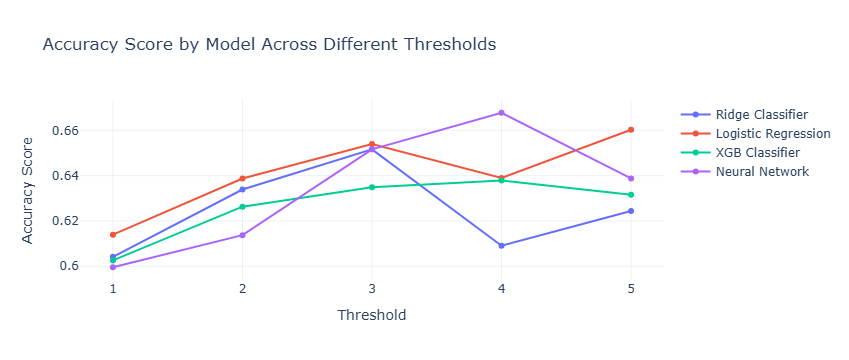

In [231]:
# Filter data for each model
ridge_data = combined_results_df[combined_results_df['Model'] == 'Ridge Classifier']
logreg_data = combined_results_df[combined_results_df['Model'] == 'Logistic Regression']
xgb_data = combined_results_df[combined_results_df['Model'] == 'XGB Classifier']
nn_data = combined_results_df[combined_results_df['Model'] == 'Neural Network']

# Extract thresholds and accuracy for each model
thresholds = combined_results_df['Threshold'].unique()
ridge_accuracy = ridge_data['Accuracy']
logreg_accuracy = logreg_data['Accuracy']
xgb_accuracy = xgb_data['Accuracy']
nn_accuracy = nn_data['Accuracy']

# Create the figure
fig = go.Figure()

# Add traces for each model
fig.add_trace(go.Scatter(x=thresholds, y=ridge_accuracy, mode='lines+markers', name='Ridge Classifier'))
fig.add_trace(go.Scatter(x=thresholds, y=logreg_accuracy, mode='lines+markers', name='Logistic Regression'))
fig.add_trace(go.Scatter(x=thresholds, y=xgb_accuracy, mode='lines+markers', name='XGB Classifier'))
fig.add_trace(go.Scatter(x=thresholds, y=nn_accuracy, mode='lines+markers', name='Neural Network'))

# Customize the layout
fig.update_layout(
    title='Accuracy Score by Model Across Different Thresholds',
    xaxis_title='Threshold',
    yaxis_title='Accuracy Score',
    template='plotly_white'
)

# Show the plot
fig.show()


In [232]:
# Round metric columns to 2 decimal places
combined_results_df[['Precision', 'Recall', 'F1-Score', 'Accuracy', 'ROC-AUC']] = combined_results_df[['Precision', 'Recall', 'F1-Score', 'Accuracy', 'ROC-AUC']].round(2)

# Create dropdowns for threshold and model
threshold_dropdown = widgets.Dropdown(
    options=[None] + sorted(combined_results_df['Threshold'].unique().tolist()),
    description='Threshold:',
    style={'description_width': 'initial'}
)

model_dropdown = widgets.Dropdown(
    options=[None] + combined_results_df['Model'].unique().tolist(),
    description='Model:',
    style={'description_width': 'initial'}
)

# Function to update and display the table based on selections
def update_table(threshold, model):
    # Filter data
    filtered_df = combined_results_df.copy()
    if threshold is not None:
        filtered_df = filtered_df[filtered_df['Threshold'] == threshold]
    if model is not None:
        filtered_df = filtered_df[filtered_df['Model'] == model]

    # Create Plotly table
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=["<b>Threshold</b>", "<b>Model</b>", "<b>Precision</b>", "<b>Recall</b>", "<b>F1-Score</b>", "<b>Accuracy</b>", "<b>ROC-AUC</b>"],
            align='center',
            font=dict(color='black', size=12),
            fill_color='lightblue',
            line_color='black'
        ),
        cells=dict(
            values=[filtered_df[col] for col in filtered_df.columns],
            align='center',
            font=dict(color='black', size=12),
            fill_color='white',
            line_color='black'
        )
    )])

    # Display the table
    fig.show()

# Display widgets and bind to the update function
interactive_output = widgets.interactive_output(update_table, {'threshold': threshold_dropdown, 'model': model_dropdown})

# Display the dropdowns and the interactive output
display(threshold_dropdown, model_dropdown, interactive_output)


Dropdown(description='Threshold:', options=(None, 1, 2, 3, 4, 5), style=DescriptionStyle(description_width='in…

Dropdown(description='Model:', options=(None, 'Neural Network', 'Logistic Regression', 'Ridge Classifier', 'XG…

Output()

# TFIDF Optimal (Neural Networks, Threshold = 4) #

- **Objective**: Train the optimal neural network model with optimal hyperparameters for detecting toxicity triggers using TF-IDF features at a fixed threshold of 4.

- **Model Training**:
  - Random seeds and deterministic settings are applied for reproducibility.
  - The dataset is balanced, with equal samples of trigger and non-trigger instances.
  - TF-IDF vectorization (with n-gram range of 1 to 3 and max features of 5000) is applied, followed by scaling with `MaxAbsScaler`.
  - Converted data is fed to a neural network with specified parameters: learning rate of 0.0001, 128 hidden units, batch size of 64, over 10 epochs.

- **Evaluation and Results**:
  - After training, the model is evaluated on precision, recall, F1-score, accuracy, and ROC-AUC, providing a robust measure of performance.
  - The trained model is saved for further usage.

- **Explainable AI Techniques**:
  - **SHAP** (SHapley Additive exPlanations): Identifies top words that contribute to the model’s prediction as triggers by computing SHAP values for each word.
  - **LIME** (Local Interpretable Model-agnostic Explanations): Provides insight into specific sample predictions by highlighting the influence of individual words in each sample.
  - **Integrated Gradients**: Assigns scores to each word based on their importance in predicting triggers, visualized in a bar chart and HTML.

- **Outputs**:
  - A list and bar plot of top words contributing to the trigger class.
  - A word cloud visualizing key terms identified as triggers, providing an interpretive layer to the neural network model’s predictions.

This phase leverages model interpretability tools (SHAP, LIME, and Integrated Gradients) to gain insight into influential words, ensuring transparency in toxicity trigger detection.

## Model Training ##

In [226]:
# Set random seeds and deterministic configurations for reproducibility
seed = 4264
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # If using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the fixed threshold
threshold = 4
print(f"\nProcessing threshold {threshold} for Neural Network")

# Prepare the dataset with the specified threshold
merged_df['trigger'] = merged_df['toxic_child_count'].apply(lambda x: 1 if x > threshold else 0)
trigger_1_sample = merged_df[merged_df['trigger'] == 1]
trigger_0_sample = merged_df[merged_df['trigger'] == 0].sample(n=trigger_1_sample.shape[0], random_state=seed)
balanced_df = pd.concat([trigger_1_sample, trigger_0_sample]).reset_index(drop=True)

X = pd.DataFrame(balanced_df['processed_text'])
y = balanced_df['trigger']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train['processed_text'])
X_test_tfidf = vectorizer.transform(X_test['processed_text'])
scaler = MaxAbsScaler()
X_train_tfidf = scaler.fit_transform(X_train_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)

# Convert the TF-IDF matrices to dense tensors
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Set hyperparameters for the model
learning_rate = 0.0001  # Choose the desired learning rate
hidden_units = 128     # Set desired number of hidden units
batch_size = 64        # Define the batch size
num_epochs = 10        # Define number of epochs

print(f"\nTraining with LR: {learning_rate}, Units: {hidden_units}, Batch: {batch_size}")

# Define DataLoader with the current batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate model, loss function, and optimizer with current hyperparameters
input_size = X_train_tfidf.shape[1]
model = NeuralNet(input_size, hidden_units)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch.float())
        loss.backward()
        optimizer.step()

# Evaluate model on test set
model.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze()
        y_pred_list.extend((y_pred > 0.5).float().numpy())
        y_true_list.extend(y_batch.numpy())

# Calculate metrics
precision = precision_score(y_true_list, y_pred_list)
recall = recall_score(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list)
accuracy = accuracy_score(y_true_list, y_pred_list)
roc_auc = roc_auc_score(y_true_list, y_pred_list)

# Print results
print(f"Results for Threshold {threshold} - LR: {learning_rate}, Units: {hidden_units}, Batch: {batch_size}")
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}, Accuracy: {accuracy}, ROC-AUC: {roc_auc}")

# Save the trained model
torch.save(model.state_dict(), f"neural_net_threshold_{threshold}.pth")
print("Model saved as neural_net_threshold_4.pth")

import pickle

# Save the vectorizer
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)


Processing threshold 4 for Neural Network

Training with LR: 0.0001, Units: 128, Batch: 64
Results for Threshold 4 - LR: 0.0001, Units: 128, Batch: 64
Precision: 0.6894977168949772, Recall: 0.652267818574514, F1-Score: 0.6703662597114317, Accuracy: 0.6710963455149501, ROC-AUC: 0.6715884547418025
Model saved as neural_net_threshold_4.pth


In [219]:
# Define the model architecture (make sure it's the same as the saved model)
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_units):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Specify the parameters used when defining the model initially
input_size = 5000  # or whatever the TF-IDF max features was
hidden_units = 128  # or the specific hidden units you used

# Instantiate the model
best_model = NeuralNet(input_size, hidden_units)

# Load the state dictionary
best_model.load_state_dict(torch.load("neural_net_threshold_4.pth"))

# Set the model to evaluation mode (important for inference)
best_model.eval()

C:\Users\irfan\AppData\Local\Temp\ipykernel_32848\1299270293.py:25: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



NeuralNet(
  (fc1): Linear(in_features=5000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

## SHAP ##

Top words contributing to the trigger class:
live         0.017707
went         0.004170
sound        0.003716
thats        0.003051
probably     0.002973
know         0.002870
well         0.002241
position     0.002234
make         0.002075
location     0.002029
dont         0.001947
sky          0.001904
game like    0.001848
full         0.001836
also         0.001792
quite        0.001779
point        0.001688
cpf          0.001657
got          0.001644
better       0.001618
Name: shap_value, dtype: float64


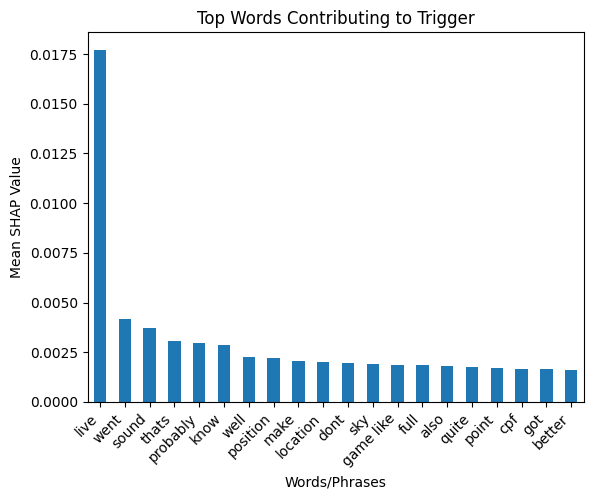

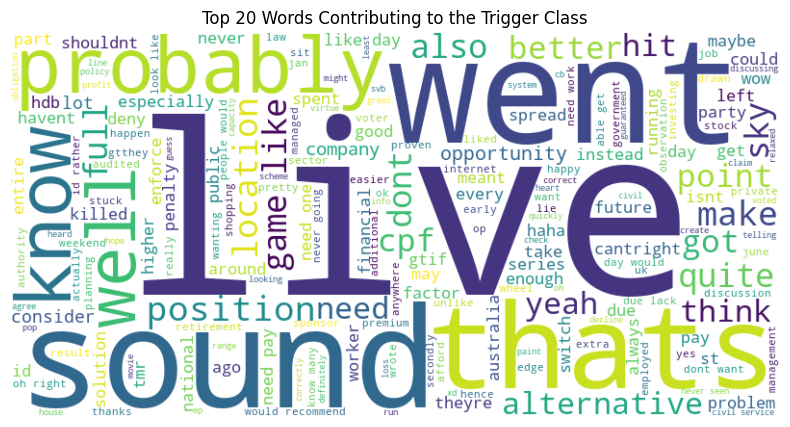

In [220]:
# Ensure model is in evaluation mode
best_model.eval()

# Use GradientExplainer from SHAP for neural networks with PyTorch
explainer = shap.GradientExplainer(best_model, X_train_tensor)

# Calculate SHAP values for a subset of the test set (to save time)
shap_values = explainer.shap_values(X_test_tensor[:100])  # Adjust the subset size if needed

# Extract SHAP values for class 1 (since it's a binary classification, use index 0 or 1)
shap_values_class_1 = shap_values[0]  # or shap_values[1] depending on the class you're analyzing

# Flatten the SHAP values and get feature names
shap_values_flattened = shap_values_class_1.flatten()
feature_names = vectorizer.get_feature_names_out()

# Ensure the length of the feature names matches the SHAP values
assert len(feature_names) == len(shap_values_flattened), "Shape mismatch between feature names and SHAP values."

# Convert SHAP values to a DataFrame
shap_df = pd.DataFrame(shap_values_flattened, columns=['shap_value'], index=feature_names)

# Calculate the mean SHAP value for each word across all test instances
mean_shap_values = shap_df.groupby(shap_df.index)['shap_value'].mean()

# Filter for words with high mean SHAP values contributing to the trigger class
top_trigger_words = mean_shap_values[mean_shap_values > 0].sort_values(ascending=False)

# Display the top words contributing to the trigger
print("Top words contributing to the trigger class:")
print(top_trigger_words[:20])

# Plot top trigger words
top_trigger_words.head(20).plot(kind='bar', title="Top Words Contributing to Trigger")
plt.xlabel("Words/Phrases")
plt.ylabel("Mean SHAP Value")
plt.xticks(rotation=45, ha='right')
plt.show()

# Generate and display word cloud
word_freq = top_trigger_words.to_dict()
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 20 Words Contributing to the Trigger Class")
plt.show()


## LIME ##

In [221]:
# Ensure `best_model` is in evaluation mode
best_model.eval()

# Define the function for LIME to make predictions with `best_model`
def lime_predict(texts):
    # Transform texts to TF-IDF vectors
    text_tfidf = vectorizer.transform(texts)
    
    # Convert to dense format and then to PyTorch tensor
    inputs = torch.tensor(text_tfidf.toarray(), dtype=torch.float32)
    
    # Move inputs to the same device as `best_model`
    inputs = inputs.to(next(best_model.parameters()).device)
    
    # Predict probabilities using the neural network
    with torch.no_grad():
        outputs = best_model(inputs).squeeze()
    
    # Convert model output to probabilities
    probs = torch.cat([1 - outputs.unsqueeze(1), outputs.unsqueeze(1)], dim=1)
    return probs.cpu().numpy()  # Return as numpy array for LIME

# Initialize LIME explainer for text
explainer = LimeTextExplainer(class_names=["Non-trigger", "Trigger"])

# Sample text for explanation
sample_text = "Sian lah, got so much work today, but never mind, just tahan a bit"

# Generate explanation with LIME
exp = explainer.explain_instance(
    sample_text, 
    lime_predict, 
    num_features=10  # Number of words to highlight
)

# Display explanation in Jupyter Notebook
exp.show_in_notebook(text=True)  # For Jupyter Notebook

# Alternatively, print explanation weights
print(exp.as_list())  # List of words and their contribution scores

[('today', 0.17513493077894282), ('got', -0.12475251565864598), ('mind', 0.08003762017886935), ('lah', -0.051941189032020225), ('never', -0.0467047985454623), ('bit', 0.041572260914912326), ('Sian', 0.0126057884066778), ('much', 0.011162719145759416), ('work', 0.004354239792607288), ('but', -0.0007240309259068904)]


## Integrated Gradients ##

In [222]:
# Define your sample text
sample_text = "This is an example of a random comment that we want to analyze"

# Tokenize the sample text manually
sample_words = sample_text.split()

# Vectorize the sample text using the TF-IDF vectorizer
sample_tfidf = vectorizer.transform([sample_text]).toarray()
input_tensor = torch.tensor(sample_tfidf, dtype=torch.float32)

# Compute attributions using Integrated Gradients
ig = IntegratedGradients(best_model)
attributions, delta = ig.attribute(input_tensor, return_convergence_delta=True)

# Convert attributions to numpy array
attributions_np = attributions.detach().numpy()[0]

# Get the words from TF-IDF and map them to their attributions
words = vectorizer.get_feature_names_out()
word_attributions = dict(zip(words, attributions_np))

# For each word in sample_text, retrieve attribution or assign zero if not found
final_tokens = []
final_attributions = []
for word in sample_words:
    final_tokens.append(word)
    final_attributions.append(word_attributions.get(word, 0))  # Use 0 if word not in TF-IDF

# Visualize attributions with HTML
html_text = ""
for token, score in zip(final_tokens, final_attributions):
    # Color red for positive attribution and green for negative attribution
    color = f"rgba(255, 0, 0, {min(1, abs(score) * 3)})" if score > 0 else f"rgba(0, 255, 0, {min(1, abs(score) * 3)})"
    style = "font-weight: bold;" if abs(score) > 0.05 else ""
    html_text += f"<span style='background-color: {color}; {style}'>{token} </span>"

display(HTML(html_text))


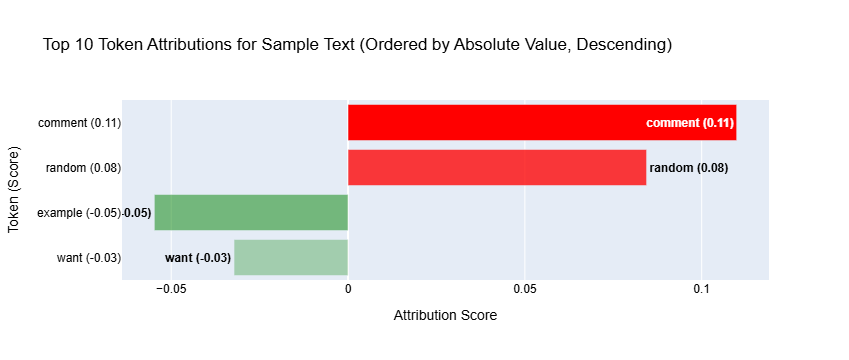

In [223]:
# Example random text
sample_text = "This is an example of a random comment that we want to analyze."

# Vectorize the sample text using the TF-IDF vectorizer
sample_tfidf = vectorizer.transform([sample_text]).toarray()
input_tensor = torch.tensor(sample_tfidf, dtype=torch.float32)

# Get the words corresponding to the features from the TF-IDF vectorizer
words = vectorizer.get_feature_names_out()

# Compute attributions using Integrated Gradients for the output class
attributions, delta = ig.attribute(input_tensor, return_convergence_delta=True)

# Convert attributions to numpy array for easier handling
attributions_np = attributions.detach().numpy()[0]

# Zip words with their corresponding attribution values for this sample
word_attributions = list(zip(words, attributions_np))

# Filter out words with zero attributions
non_zero_word_attributions = [(word, attr) for word, attr in word_attributions if abs(attr) > 0]

# Sort words by their attribution value (descending)
sorted_word_attributions = sorted(non_zero_word_attributions, key=lambda x: abs(x[1]), reverse=True)[:10]

# Convert to DataFrame for easy manipulation
df = pd.DataFrame(sorted_word_attributions, columns=["Token", "Attribution Score"])
df["Token + Score"] = df["Token"] + " (" + df["Attribution Score"].round(2).astype(str) + ")"
df = df[::-1]  # Reverse for descending y-axis order

# Set colors with varying intensity based on the attribution score
max_abs_score = max(abs(df["Attribution Score"]))
colors = [
    f'rgba(255, 0, 0, {min(1, abs(score) / max_abs_score)})' if score > 0 else 
    f'rgba(0, 128, 0, {min(1, abs(score) / max_abs_score)})' 
    for score in df["Attribution Score"]
]

# Prepare text positions based on score magnitude
text_positions = ["inside" if abs(score) > 0.1 else "outside" for score in df["Attribution Score"]]

# Create the bar chart
fig = go.Figure(go.Bar(
    x=df["Attribution Score"],
    y=df["Token + Score"],
    orientation='h',
    marker=dict(color=colors),
    text=["<b>" + label + "</b>" for label in df["Token + Score"]],  # Bold labels
    textposition=text_positions,
    texttemplate='%{text}'
))

# Update layout to maintain the sorted order on the y-axis in descending and set font to bold
fig.update_layout(
    title="Top 10 Token Attributions for Sample Text (Ordered by Absolute Value, Descending)",
    xaxis_title="Attribution Score",
    yaxis_title="Token (Score)",
    yaxis=dict(categoryarray=df["Token + Score"], categoryorder="array"),
    font=dict(family="Arial", size=12, color="black")
)

fig.show()